<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback


In [11]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [31]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizeValues(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PreparaDados(df):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = df[target].copy(deep=True)
  df["SalesTwoWeeksAgo"] = df[target].copy(deep=True)
  df["SalesThreeWeeksAgo"] = df[target].copy(deep=True)

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if (i-1)>0 else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if (i-2)>0 else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if (i-3)>0 else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
  NormalizeValues(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train, X_test, y_train, y_test

In [32]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df)
print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [33]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
#X_train.info()

In [15]:
X_train_ = X_train.values;
X_test_ = X_test.values;

corte = int(len(X_train_)*0.9)
X_validation = X_train_[corte:]
X_train_ = X_train_[:corte]
y_validation = y_train[corte:]
y_train = y_train[:corte]

In [16]:
def get_model():
    number_features = 66
    model = Sequential([
        Dense(36, input_shape = (number_features,), activation = 'relu'),
        Dense(36, activation = 'relu'),
        Dense(360, activation = 'relu'),
        Dense(360, activation = 'relu'),
        Dense(180, activation = 'relu'),
        Dense(180, activation = 'relu'),
        Dense(180, activation = 'relu'),
        Dense(90, activation = 'relu'),
        Dense(90, activation = 'relu'),
        Dense(30, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(1)
    ])
    
    model.compile(
         loss = 'mse',
         optimizer = 'adam'    
    )
    return model


In [17]:
def get_model2():
    number_features = 66
    model = Sequential([
        Dense(64, input_shape = (number_features,), activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(320, activation = 'relu'),
        Dense(320, activation = 'relu'),
        Dense(160, activation = 'relu'),
        Dense(160, activation = 'relu'),
        Dense(160, activation = 'relu'),
        Dense(80, activation = 'relu'),
        Dense(80, activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
         loss = 'mse',
         optimizer = optimizer,    
         metrics=['mae', 'mse'])
    return model


In [23]:
model = get_model()
history = model.fit(
        X_train_,y_train,
        validation_data =(X_validation, y_validation),
        epochs = 100
)

Epoch 1/100
127/127 [==============================] - 2s 8ms/step - loss: 212071661568.0000 - val_loss: 15236654080.0000
Epoch 2/100
127/127 [==============================] - 1s 9ms/step - loss: 40817410048.0000 - val_loss: 14482413568.0000
Epoch 3/100
127/127 [==============================] - 1s 7ms/step - loss: 37354307584.0000 - val_loss: 13433994240.0000
Epoch 4/100
127/127 [==============================] - 1s 7ms/step - loss: 36544466944.0000 - val_loss: 12491295744.0000
Epoch 5/100
127/127 [==============================] - 1s 7ms/step - loss: 35755515904.0000 - val_loss: 13841364992.0000
Epoch 6/100
127/127 [==============================] - 1s 7ms/step - loss: 36879966208.0000 - val_loss: 10529725440.0000
Epoch 7/100
127/127 [==============================] - 1s 7ms/step - loss: 33919938560.0000 - val_loss: 9293324288.0000
Epoch 8/100
127/127 [==============================] - 1s 7ms/step - loss: 35464671232.0000 - val_loss: 10795294720.0000
Epoch 9/100
127/127 [===========

In [36]:
predictions = model.predict(X_test)

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9674377402595636, 61813.004, 96814.18)

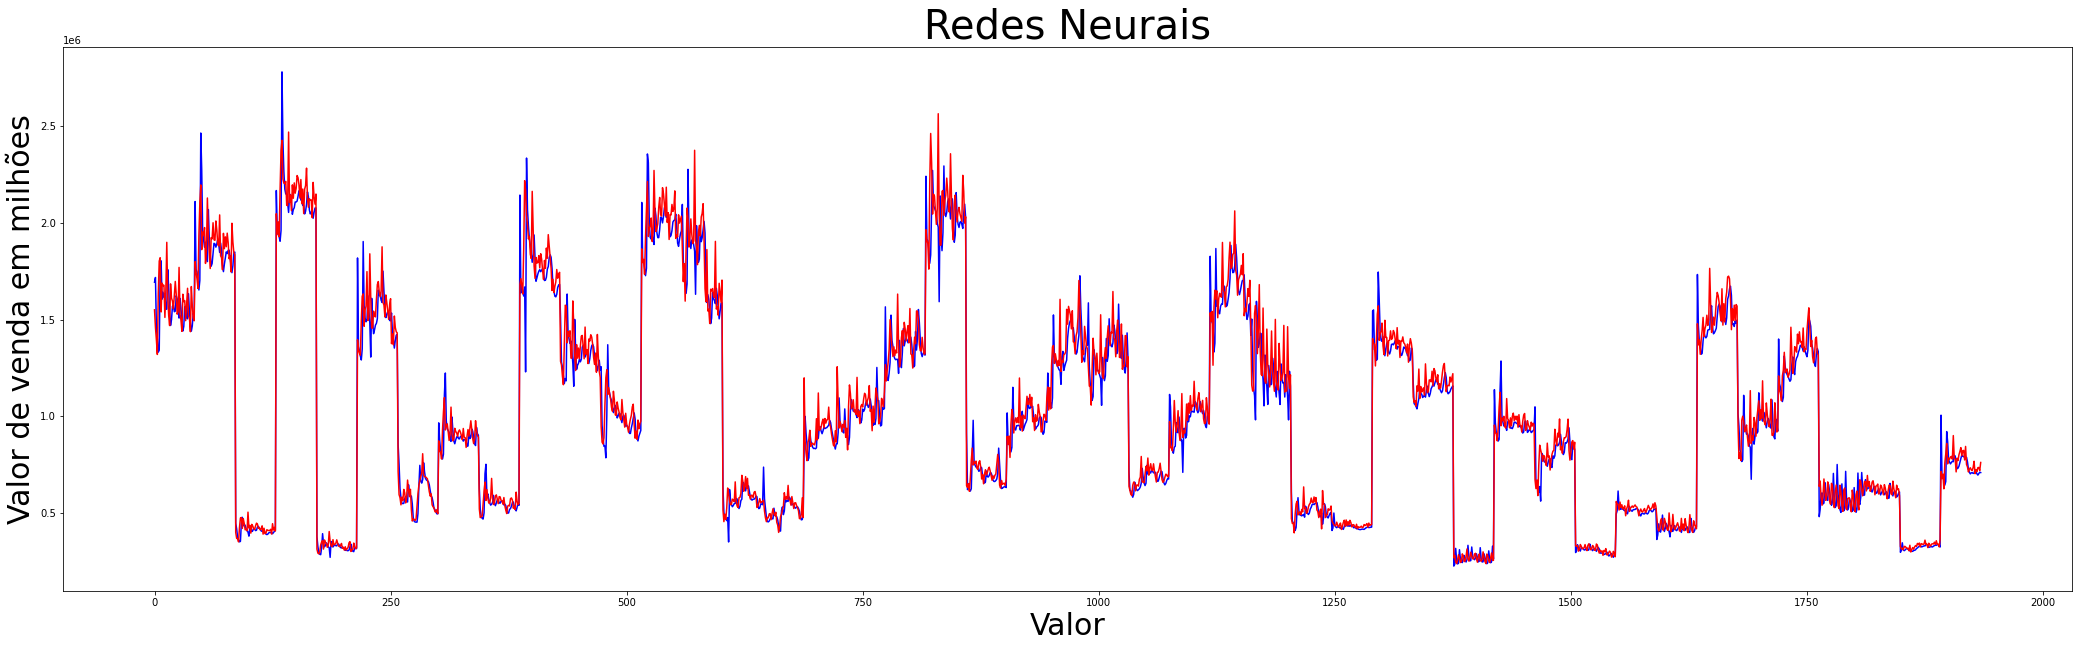

In [20]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Redes Neurais", fontsize=40)
plt.xlabel("Valor", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

Resultados Loja 1:
-0.8438677762124425 118770.03 154441.25


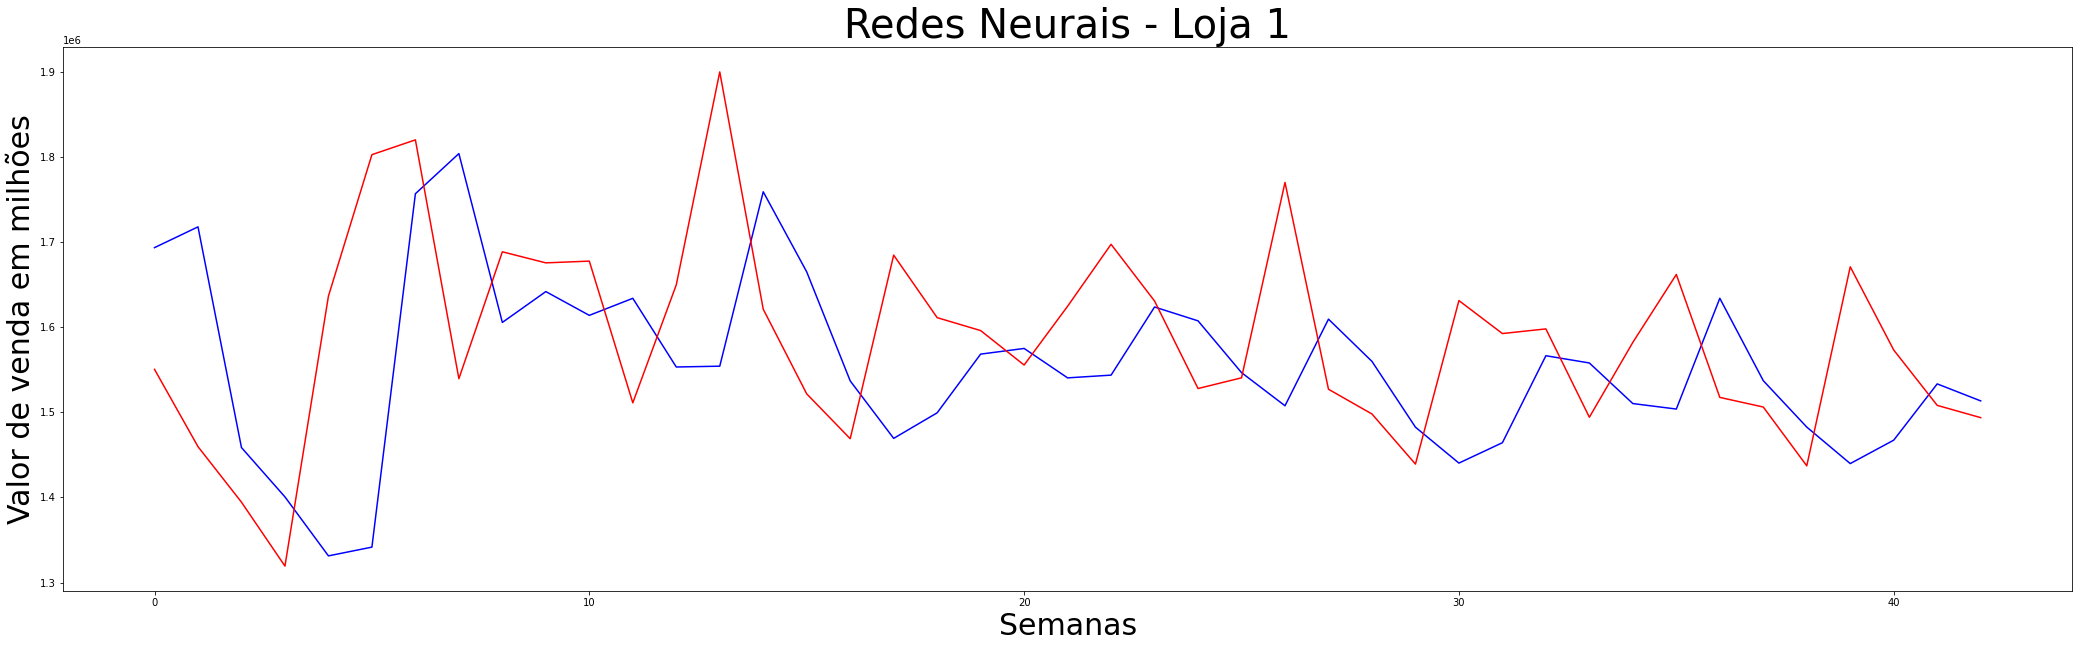

**************************************************
Resultados Loja 2:
-1.0800450095795466 109688.64 154807.28


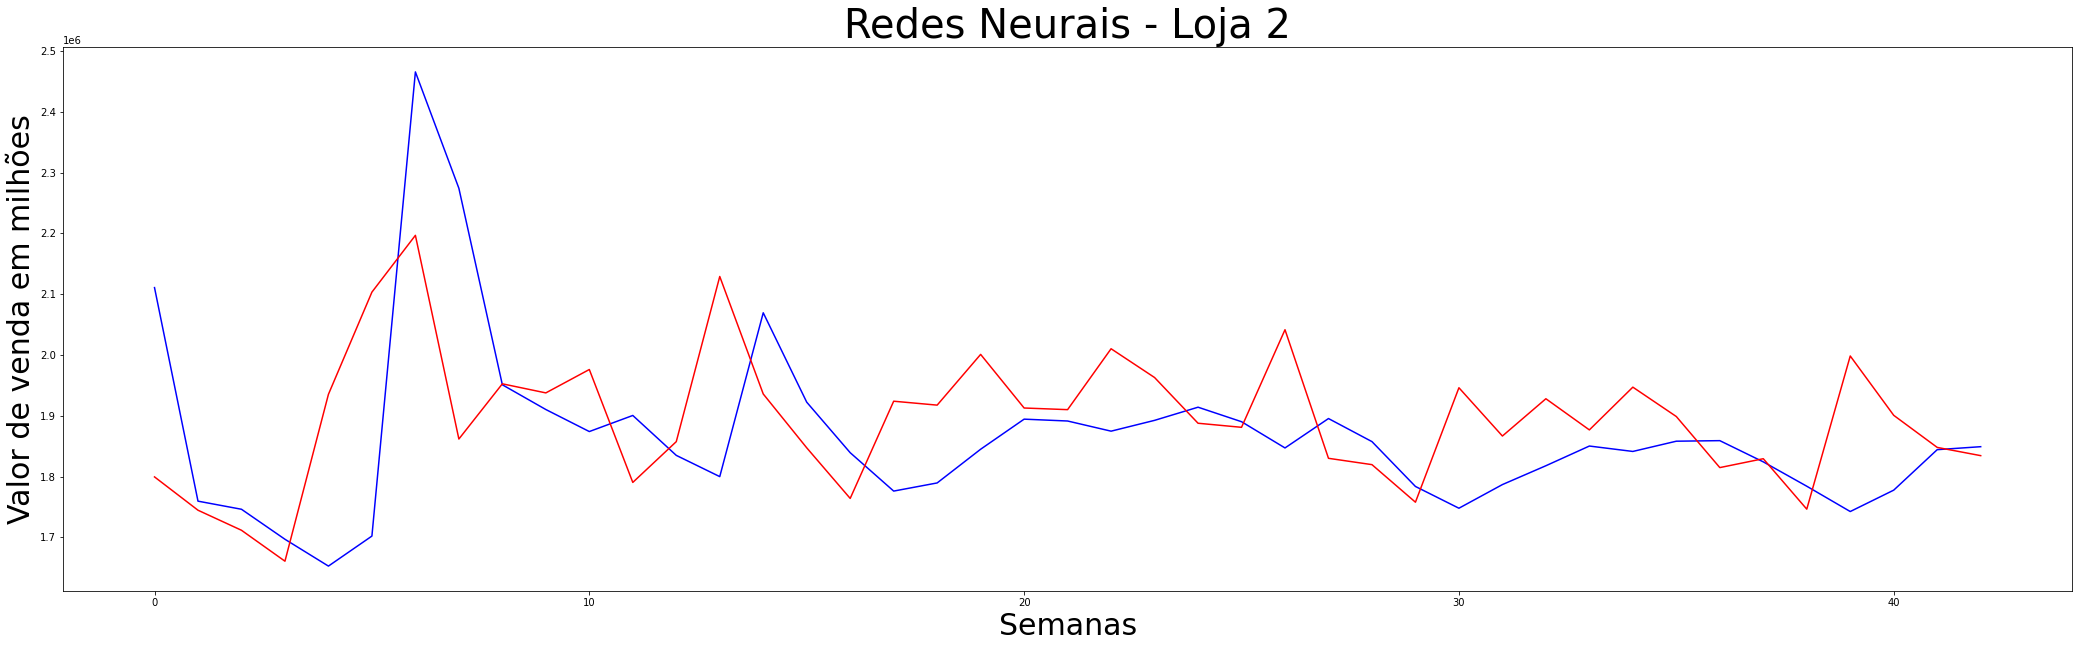

**************************************************
Resultados Loja 3:
-0.5951101891787685 25124.506 36054.9


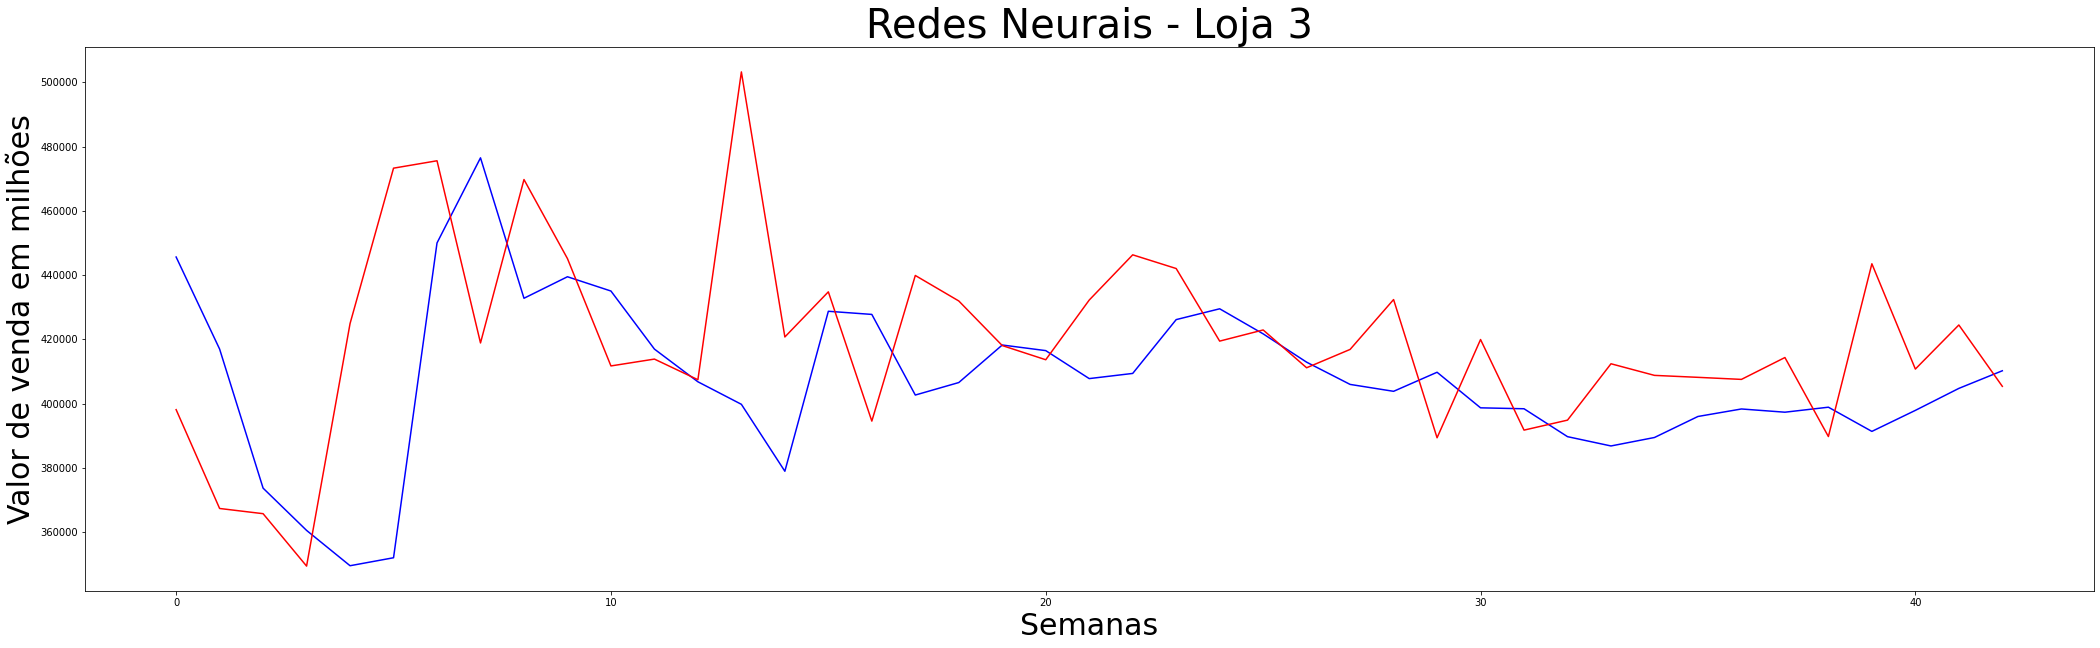

**************************************************
Resultados Loja 4:
-0.7657328024805867 99294.97 140266.67


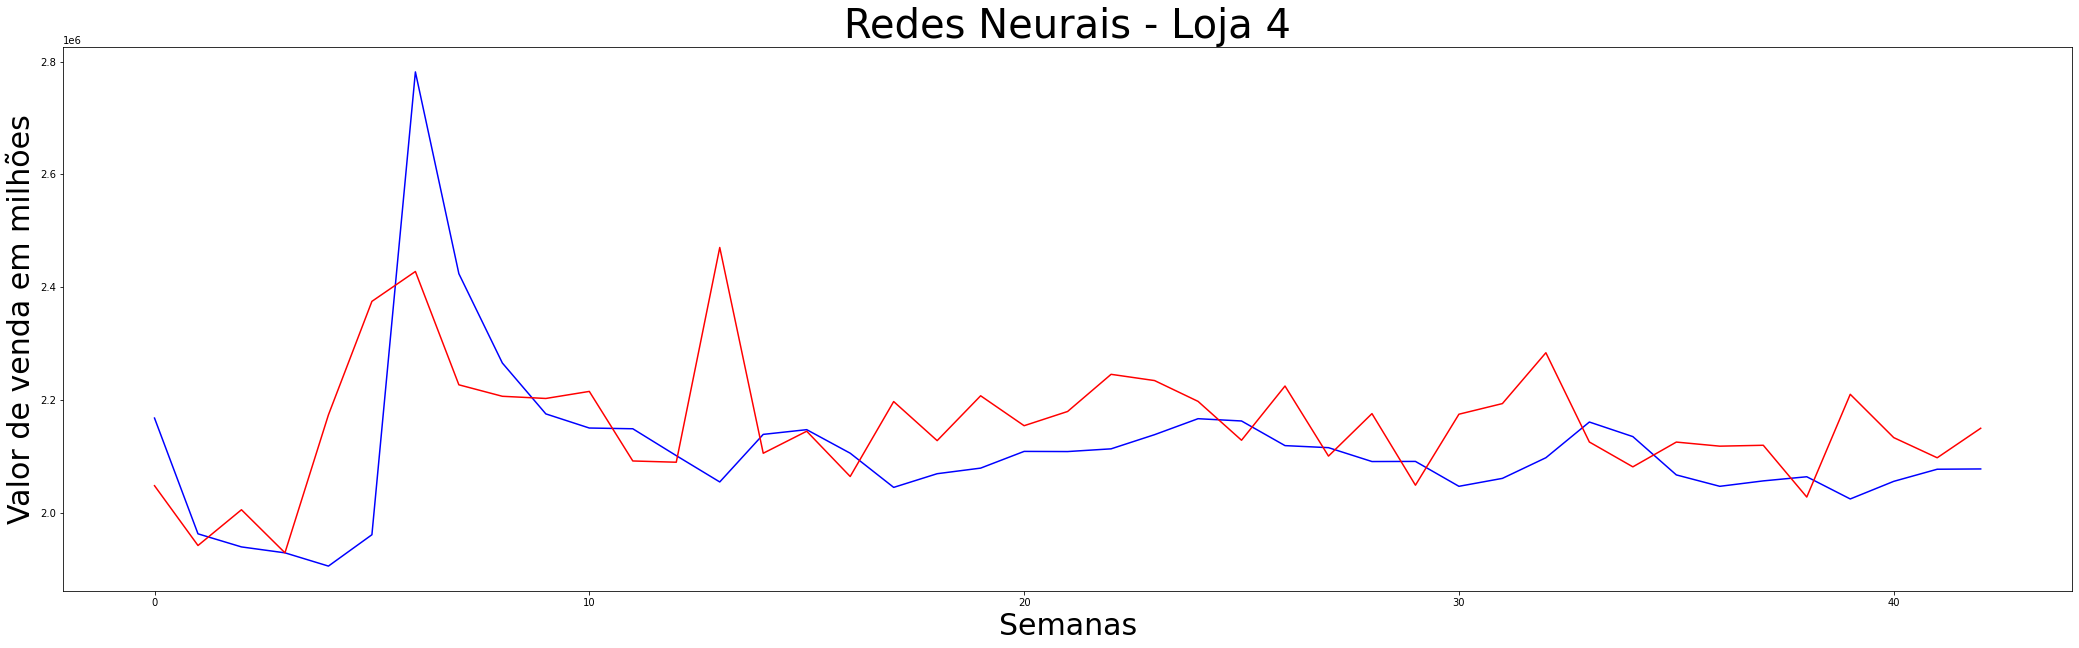

**************************************************
Resultados Loja 5:
-0.8292705226410002 21326.105 29463.01


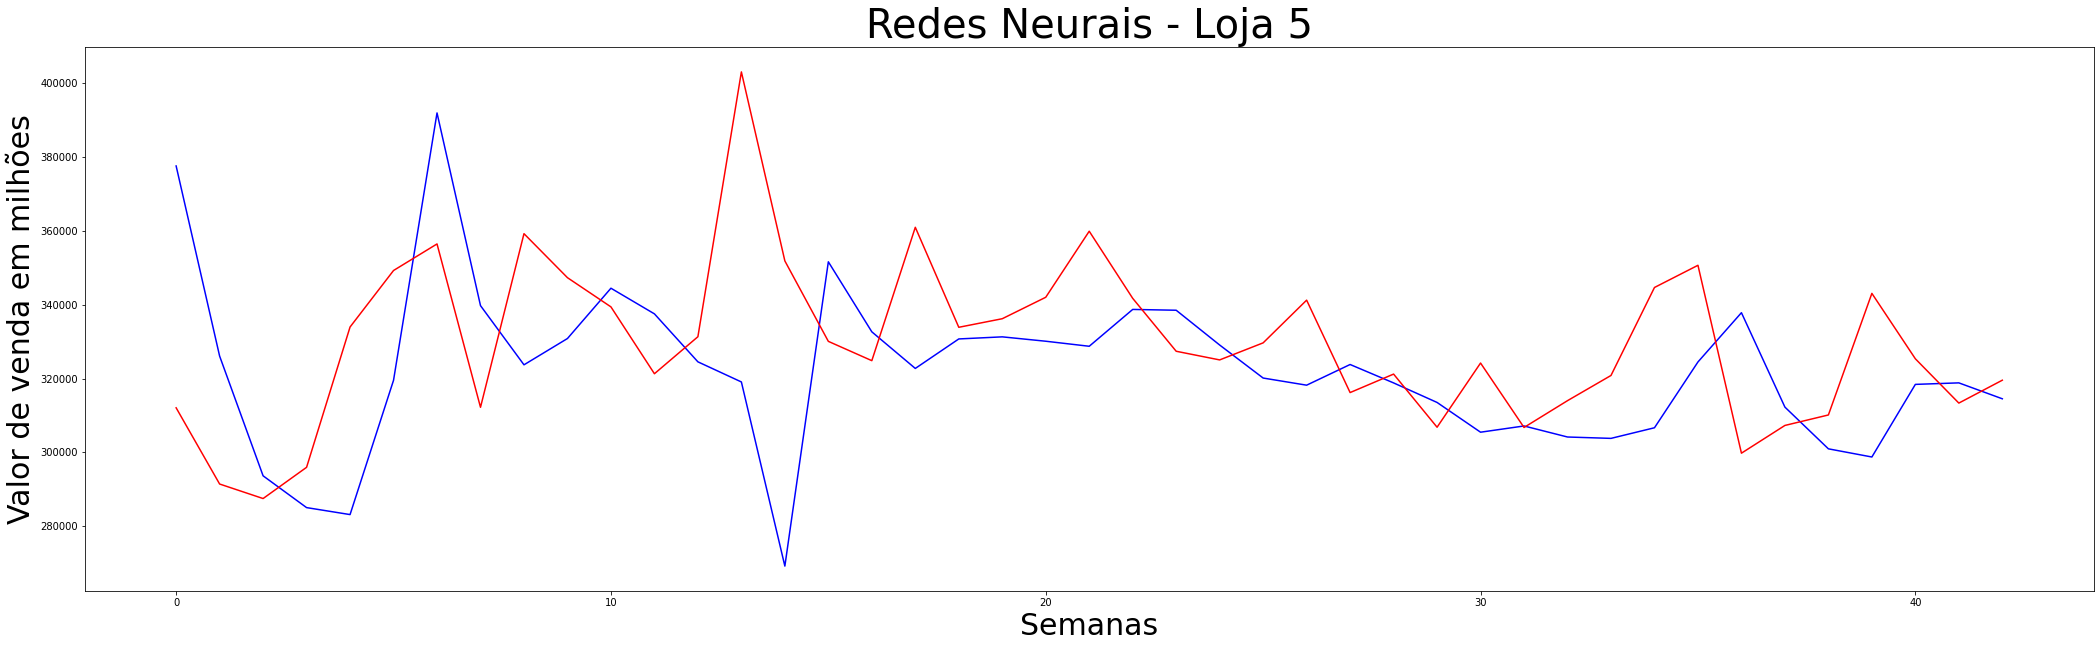

**************************************************
Resultados Loja 6:
-0.549878442842118 111248.76 152679.1


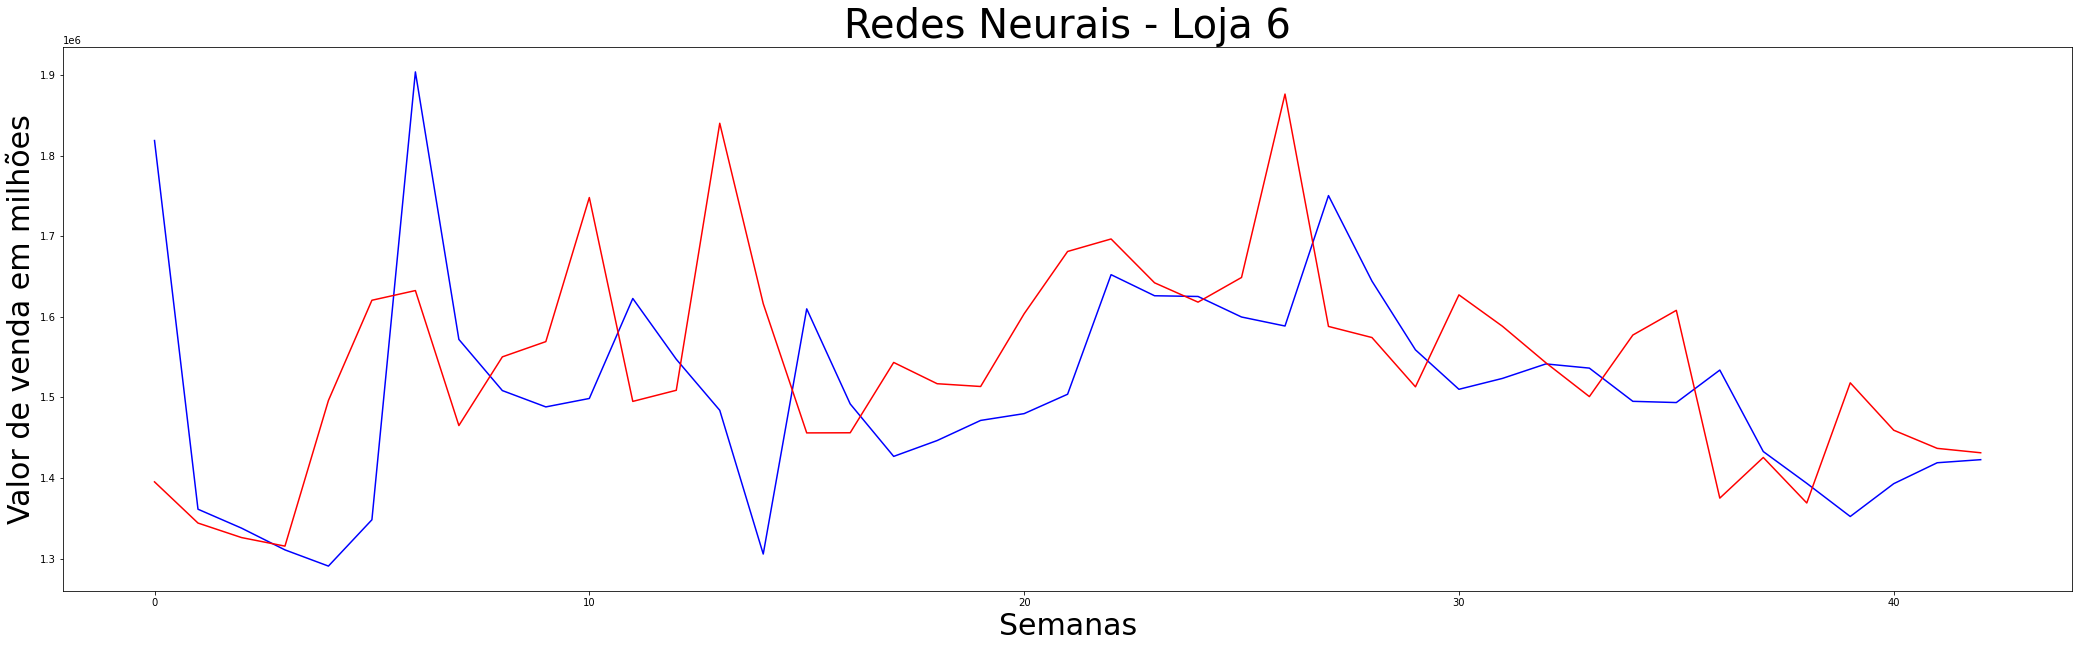

**************************************************
Resultados Loja 7:
0.5046427258275521 41096.574 57050.76


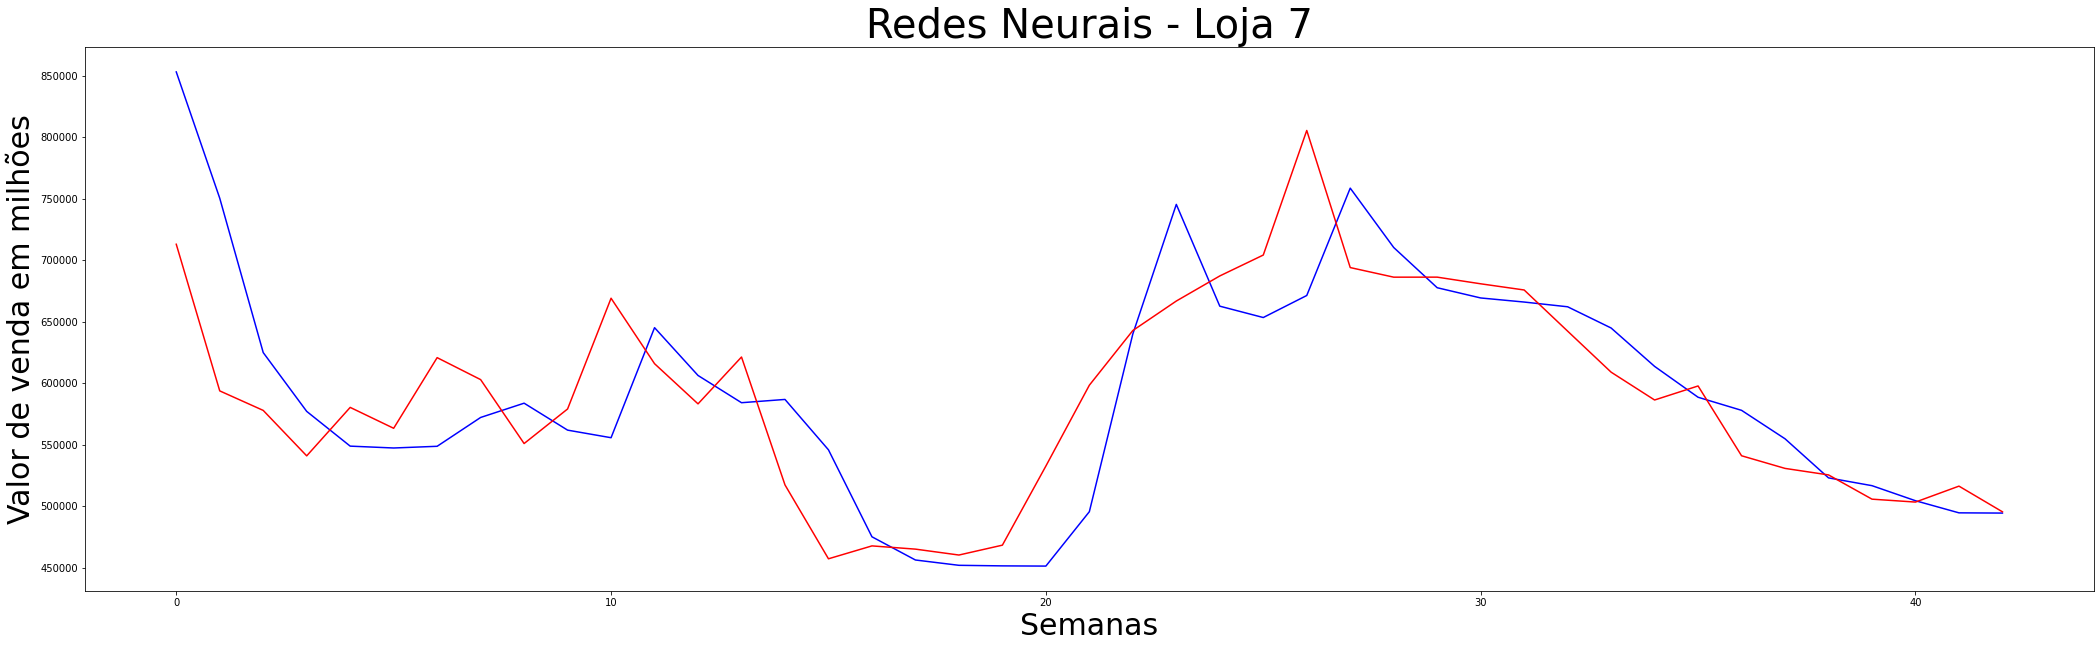

**************************************************
Resultados Loja 8:
-1.0184440933133905 52255.355 79838.375


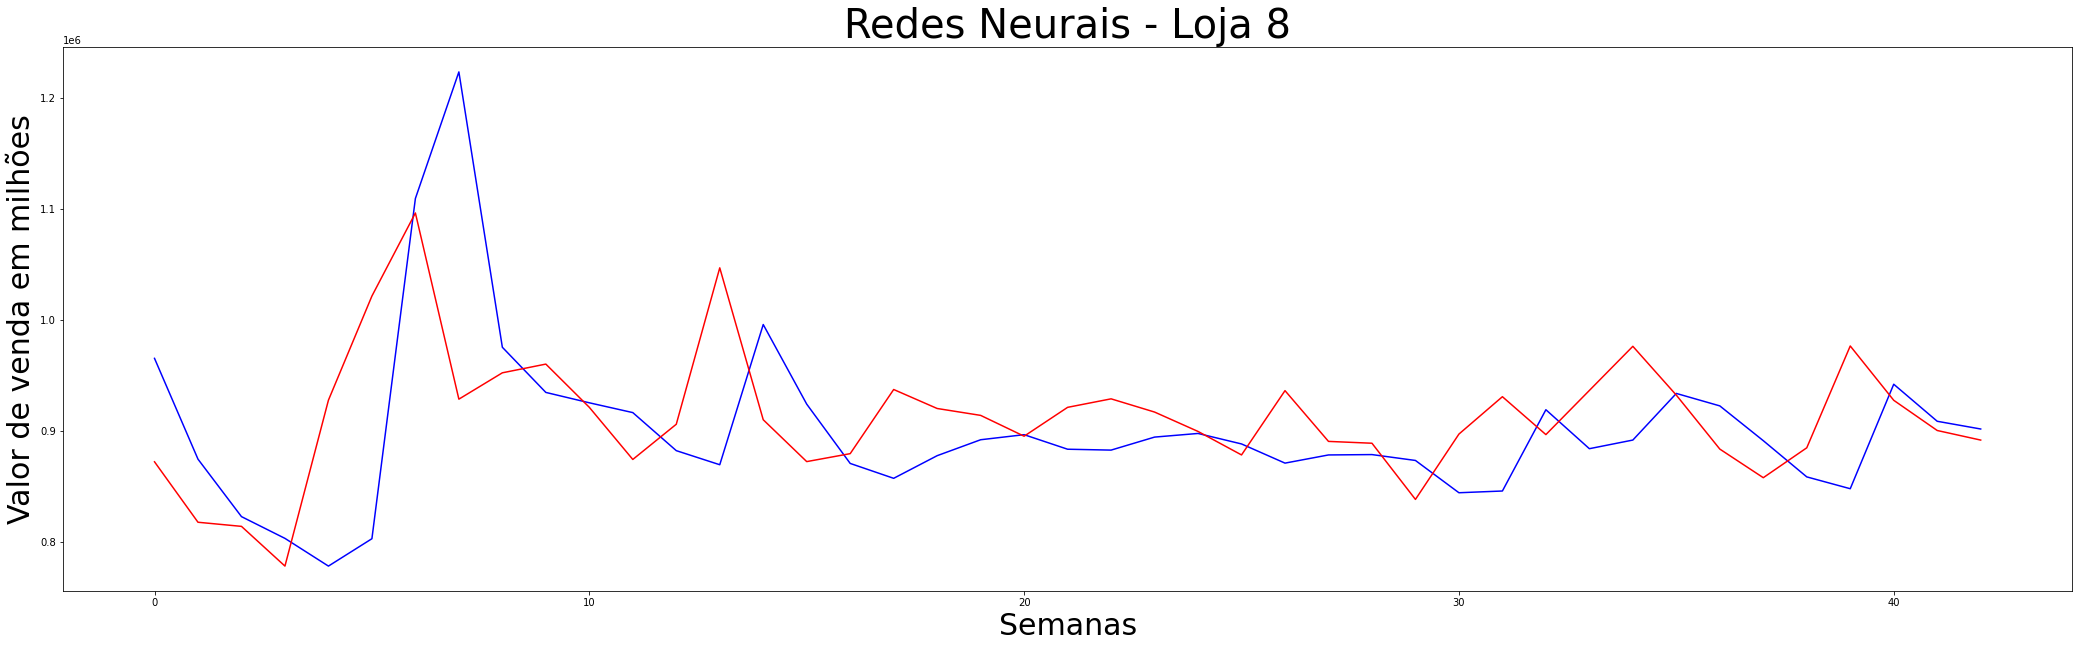

**************************************************
Resultados Loja 9:
-0.6926058906368029 36339.176 53032.875


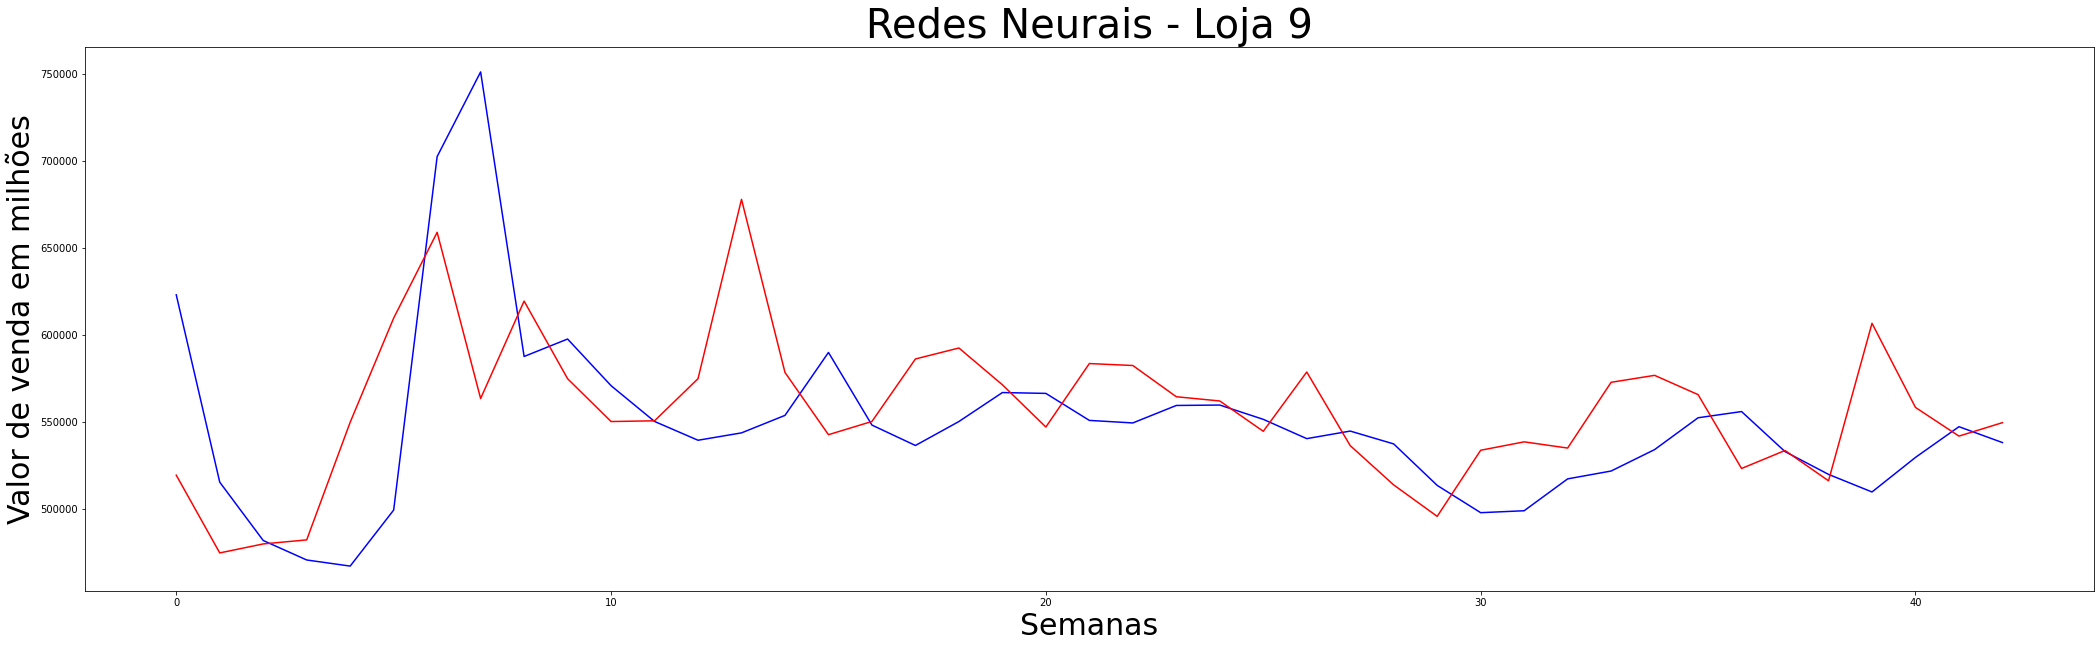

**************************************************
Resultados Loja 10:
-1.3709753716579476 124611.07 211469.06


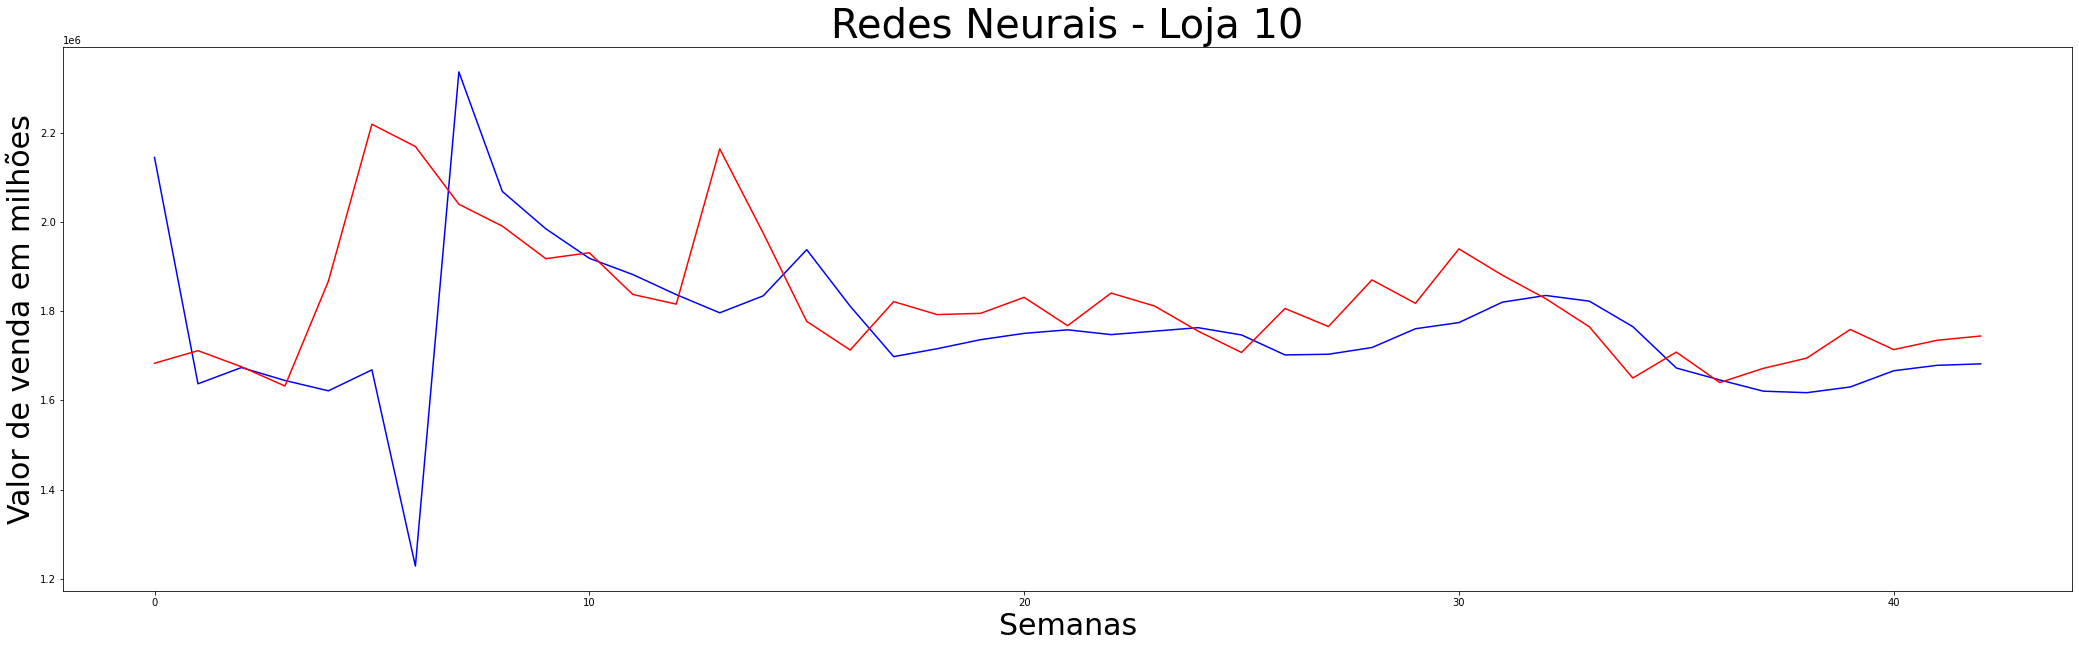

**************************************************
Resultados Loja 11:
-1.2138205322236533 101726.375 143331.52


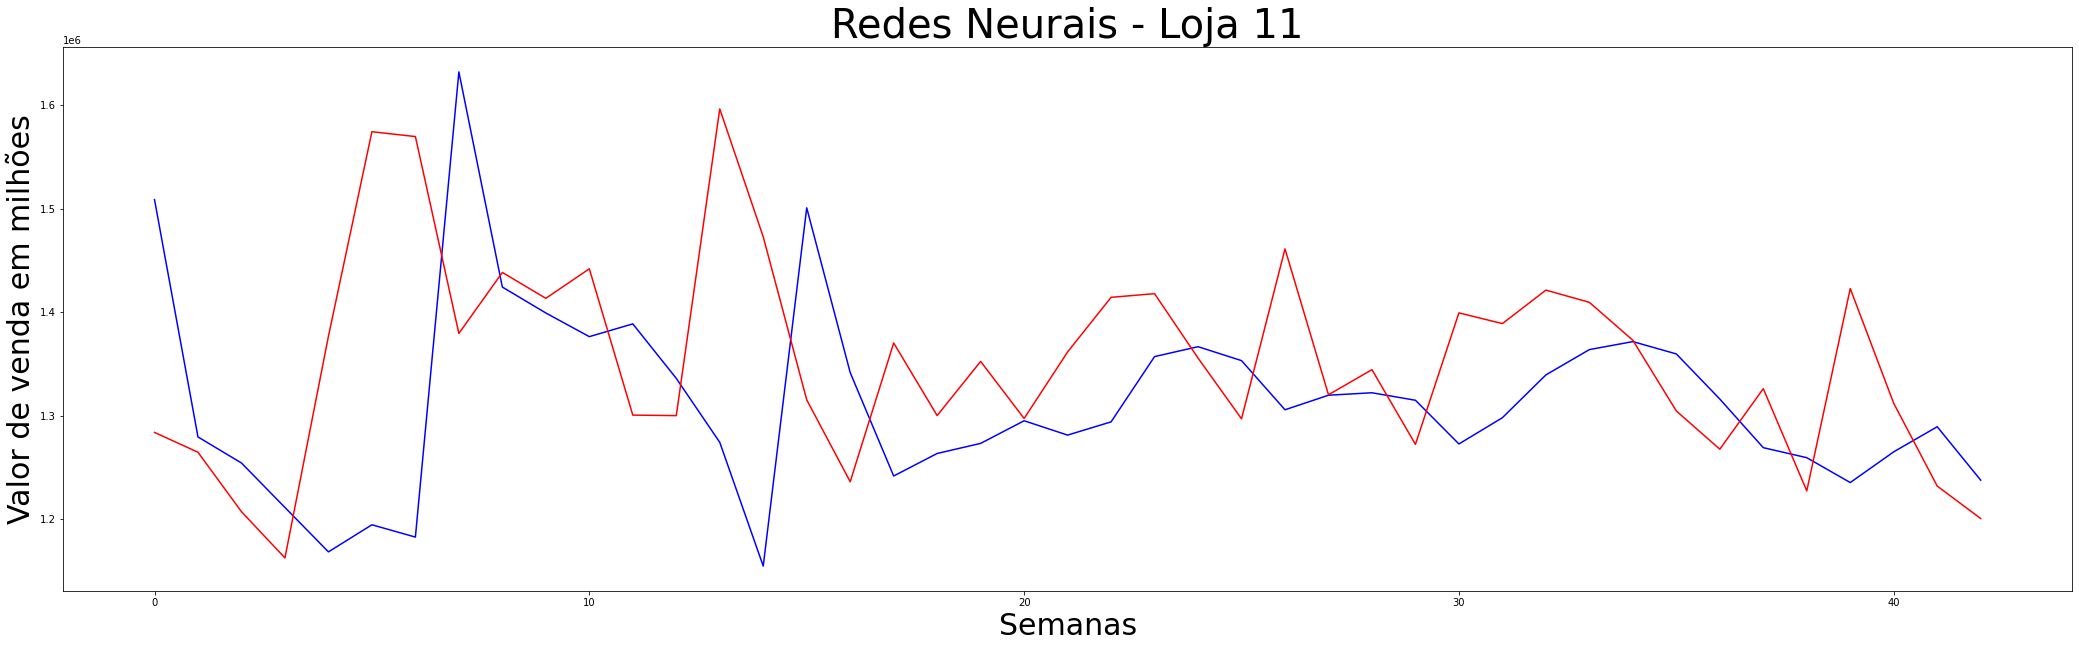

**************************************************
Resultados Loja 12:
-0.7573941327525275 72954.836 113570.41


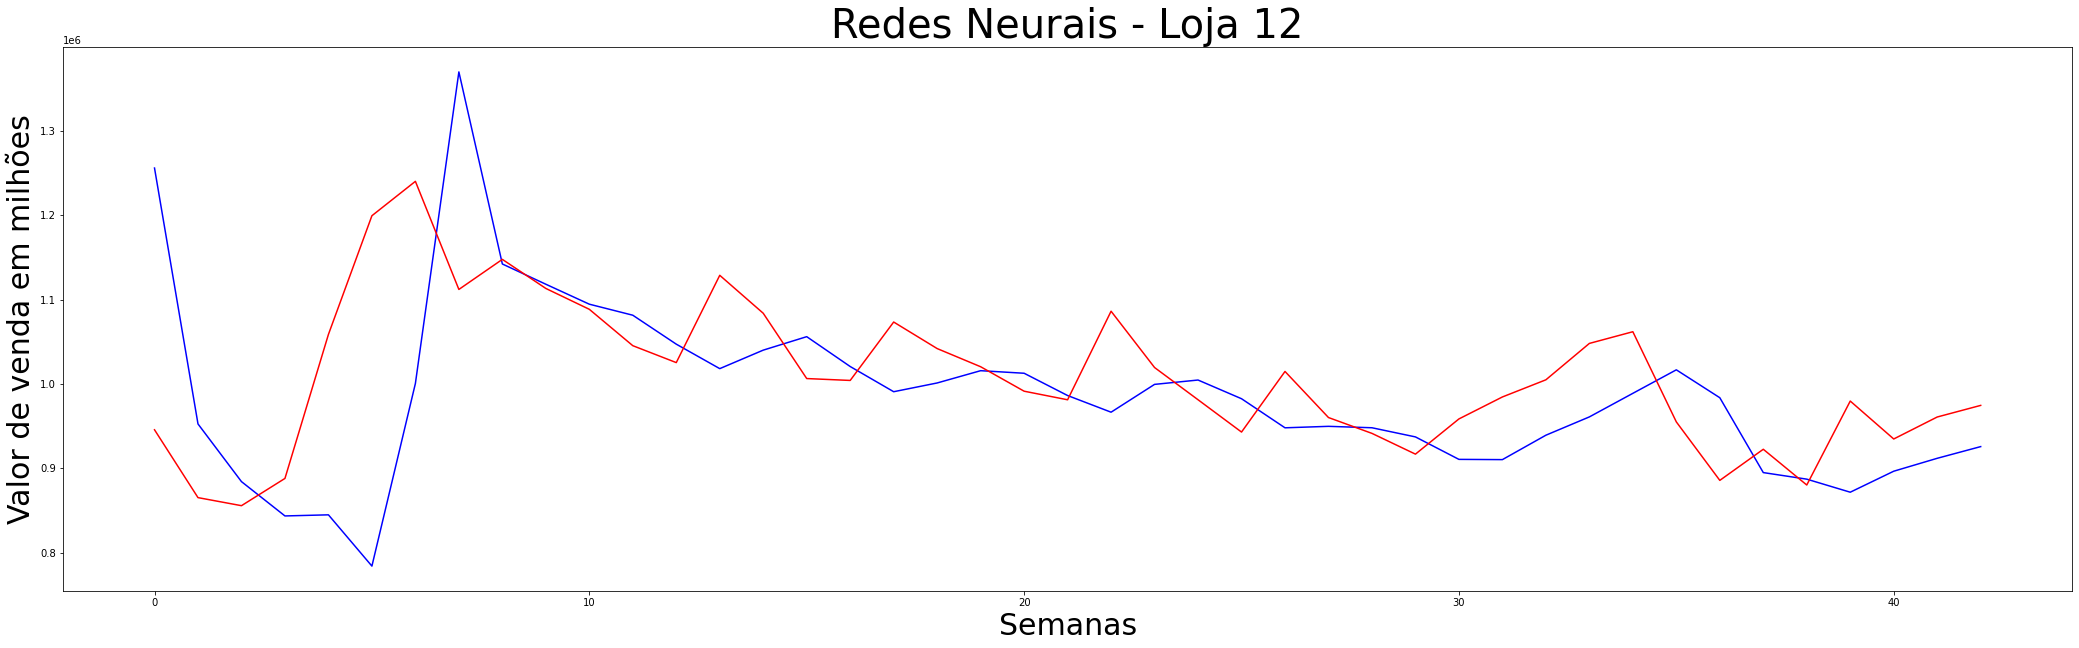

**************************************************
Resultados Loja 13:
-0.5709060104288062 102636.43 137210.42


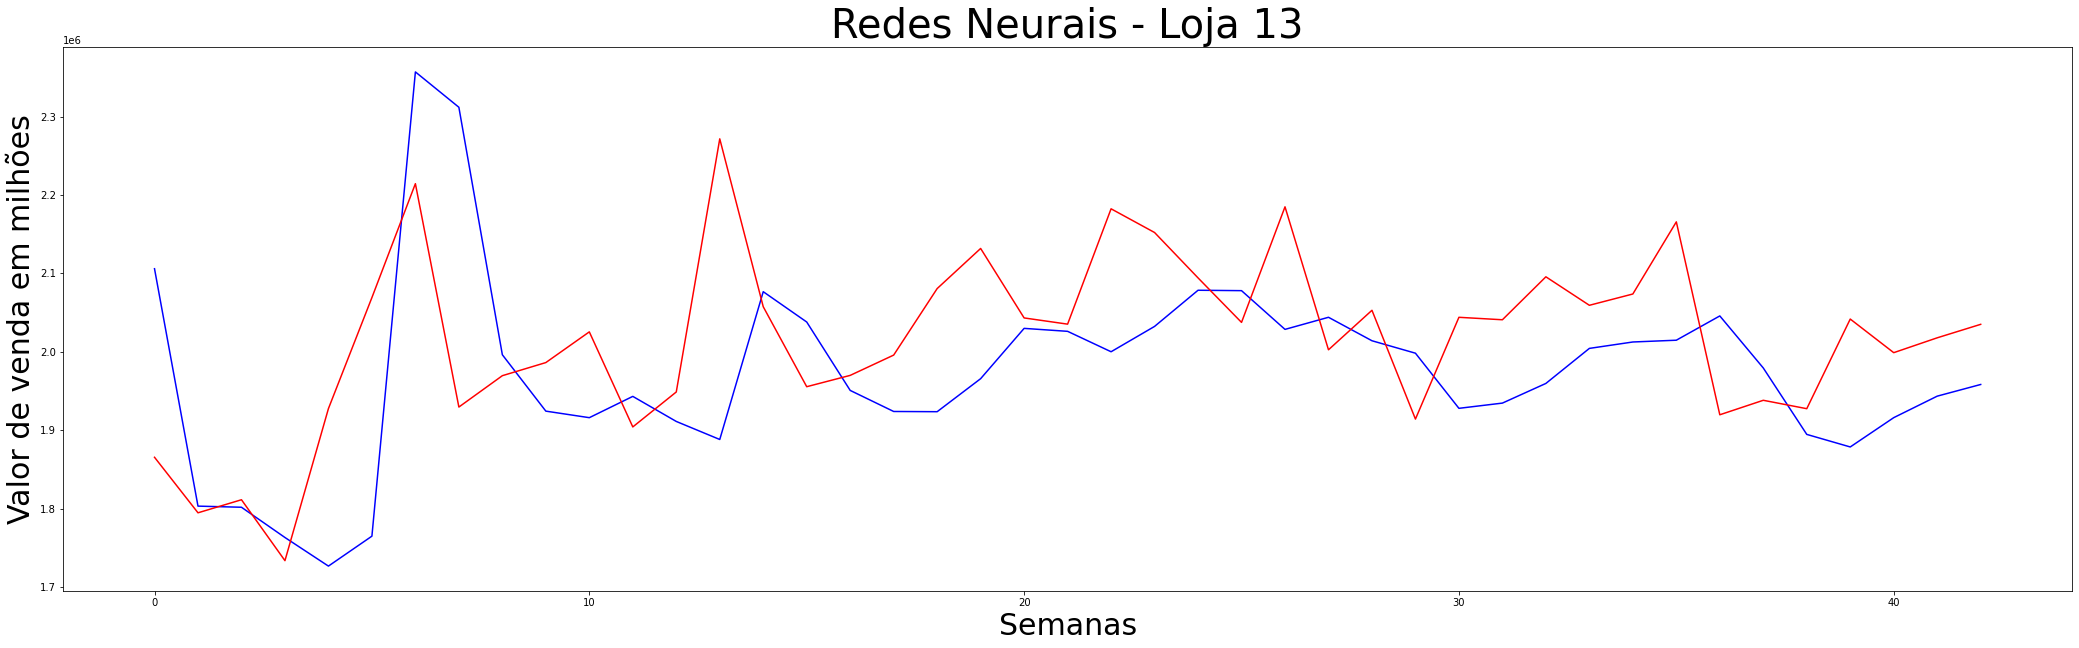

**************************************************
Resultados Loja 14:
0.2152474022912233 134376.11 174021.95


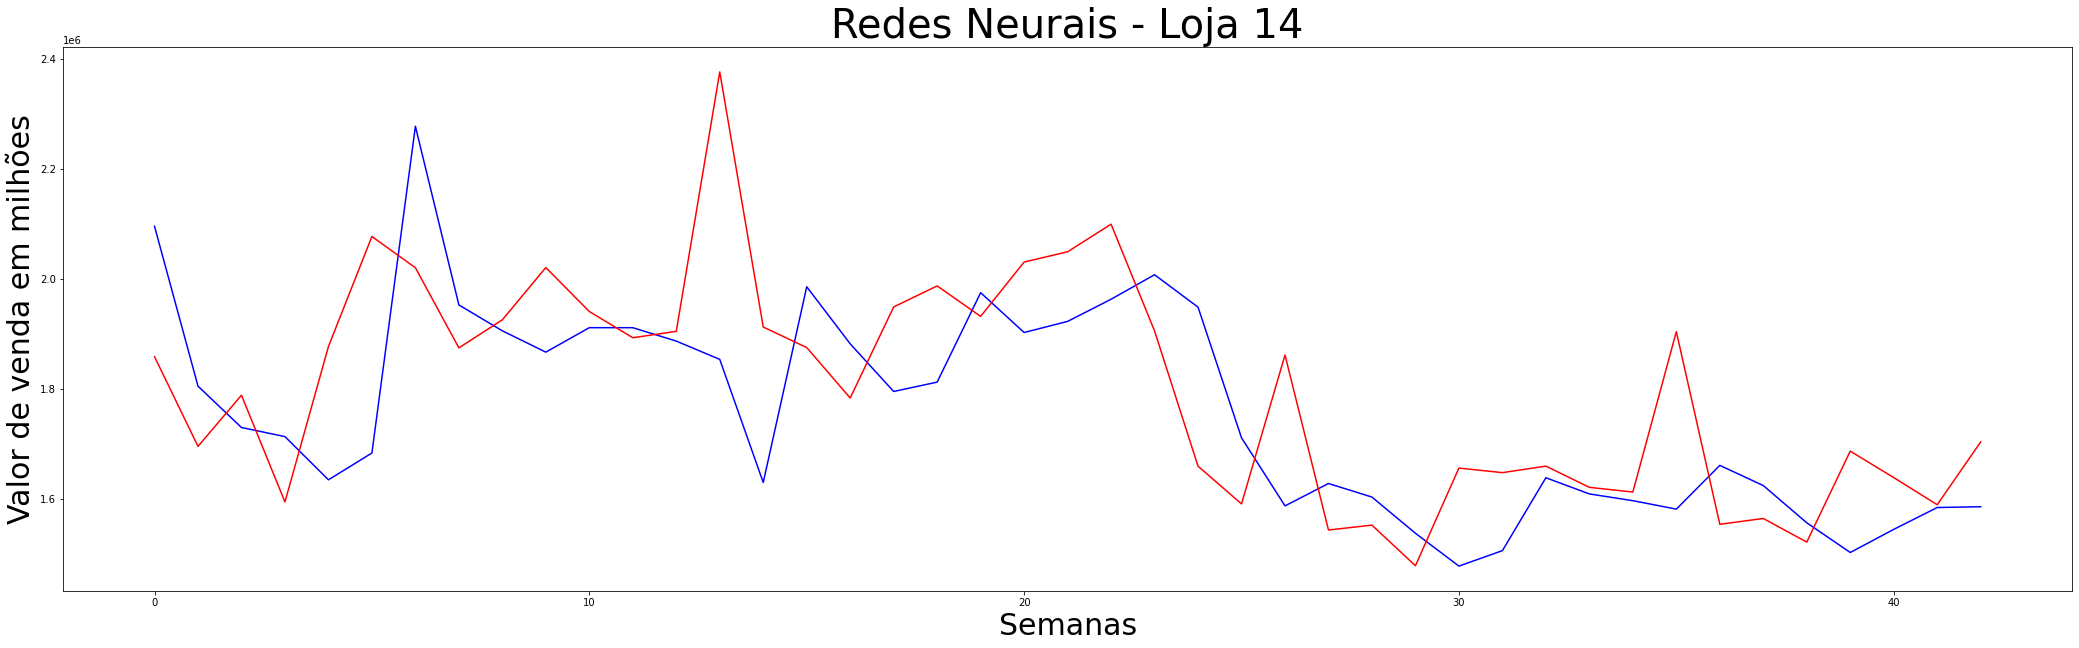

**************************************************
Resultados Loja 15:
-0.46205254625466696 43396.516 63601.117


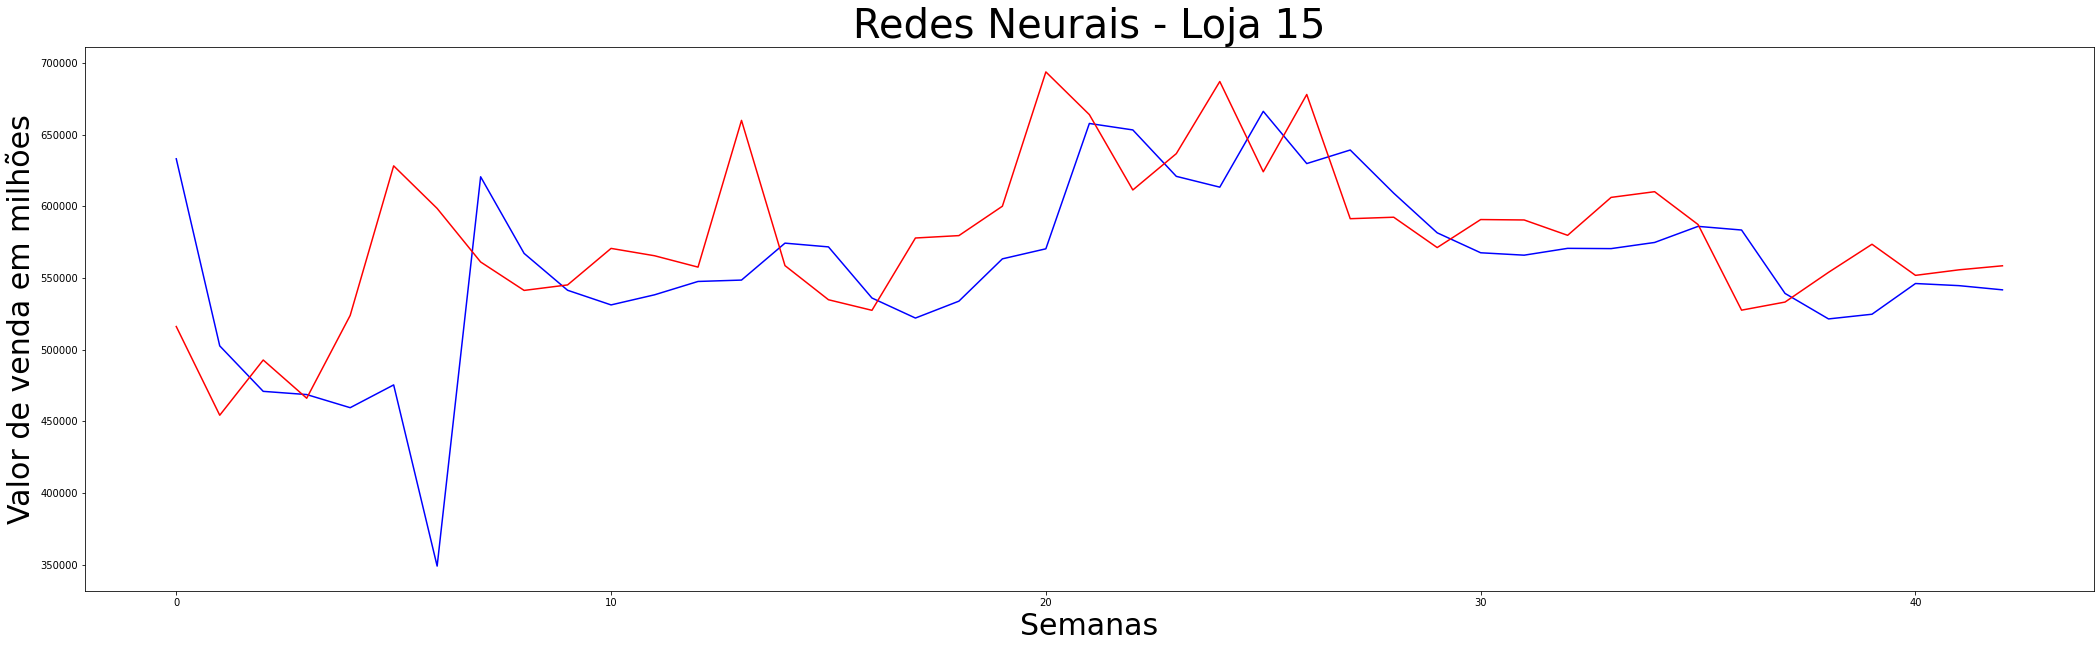

**************************************************
Resultados Loja 16:
0.1656566676223019 33209.54 46215.742


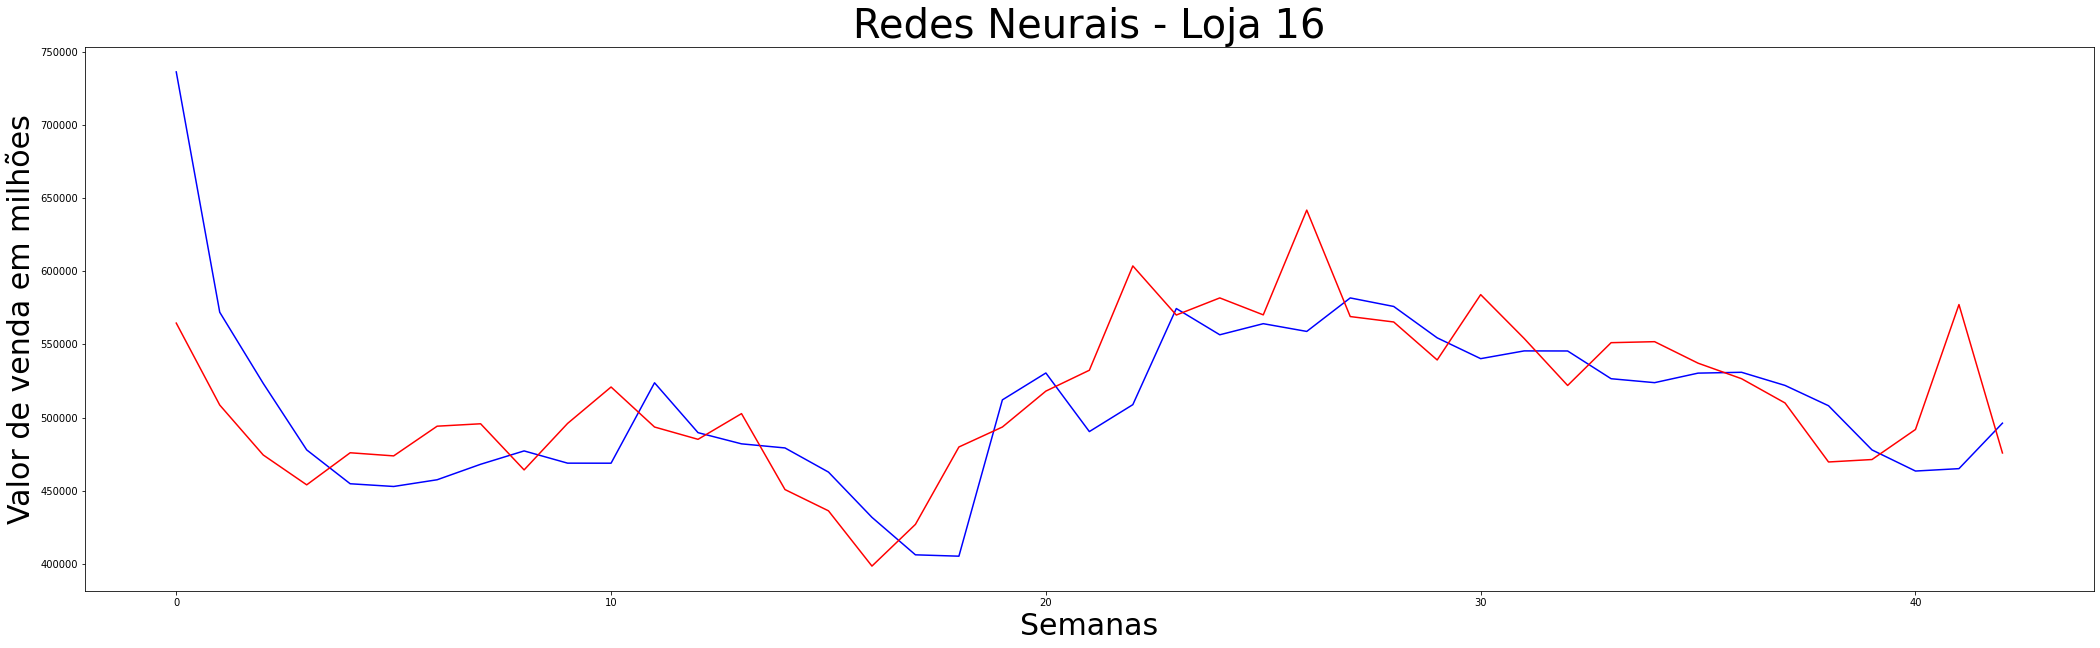

**************************************************
Resultados Loja 17:
-0.35164901114015534 67275.27 108619.43


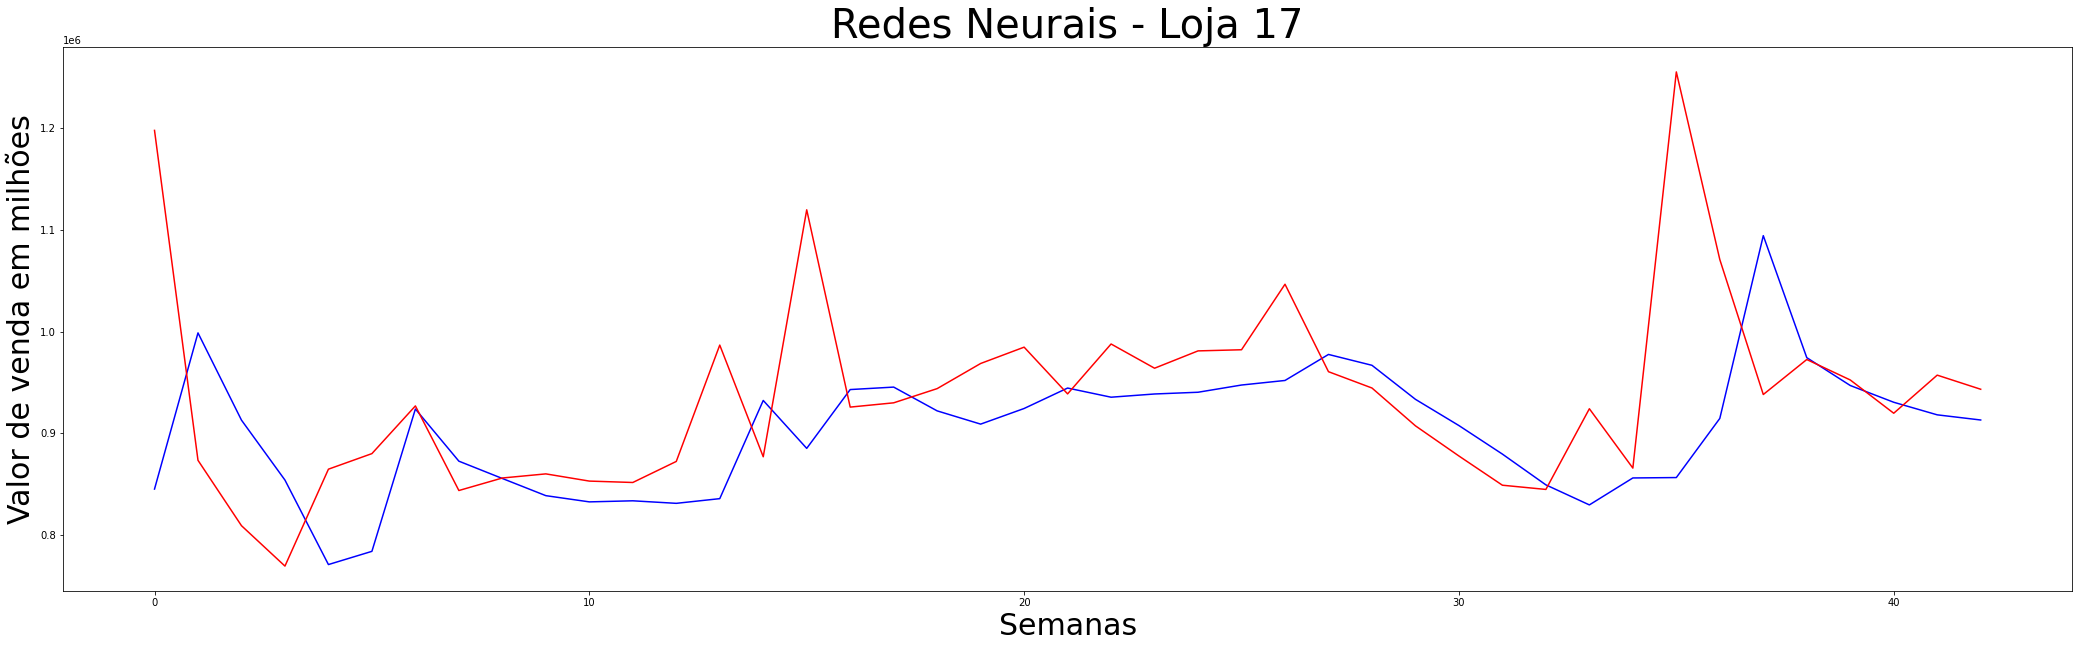

**************************************************
Resultados Loja 18:
-0.46840217339222345 66971.36 89660.06


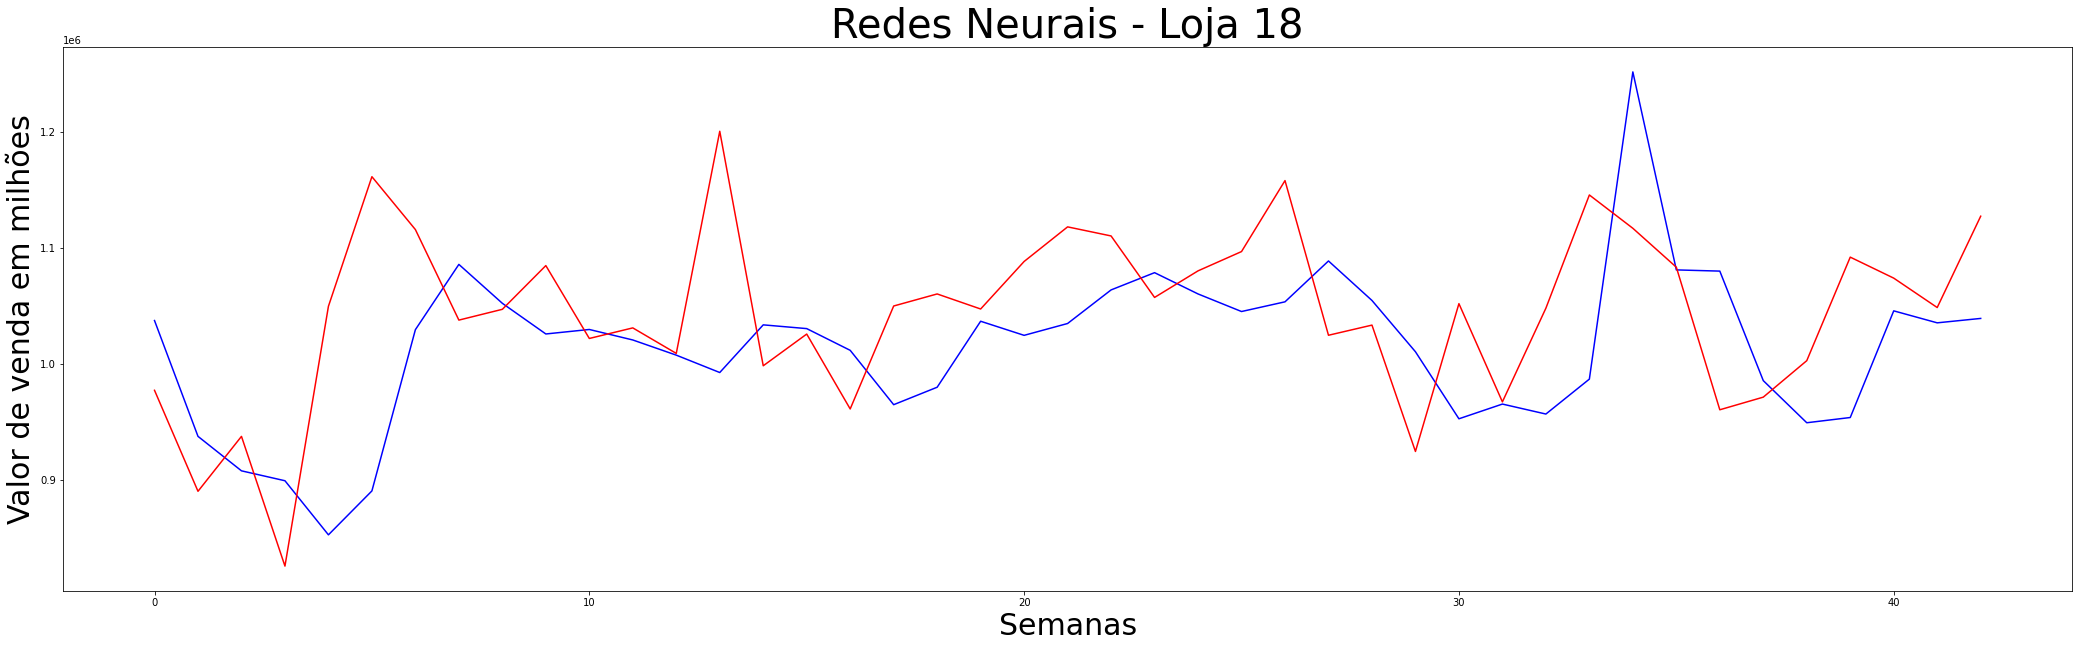

**************************************************
Resultados Loja 19:
-0.5629642555213947 90596.734 116338.3


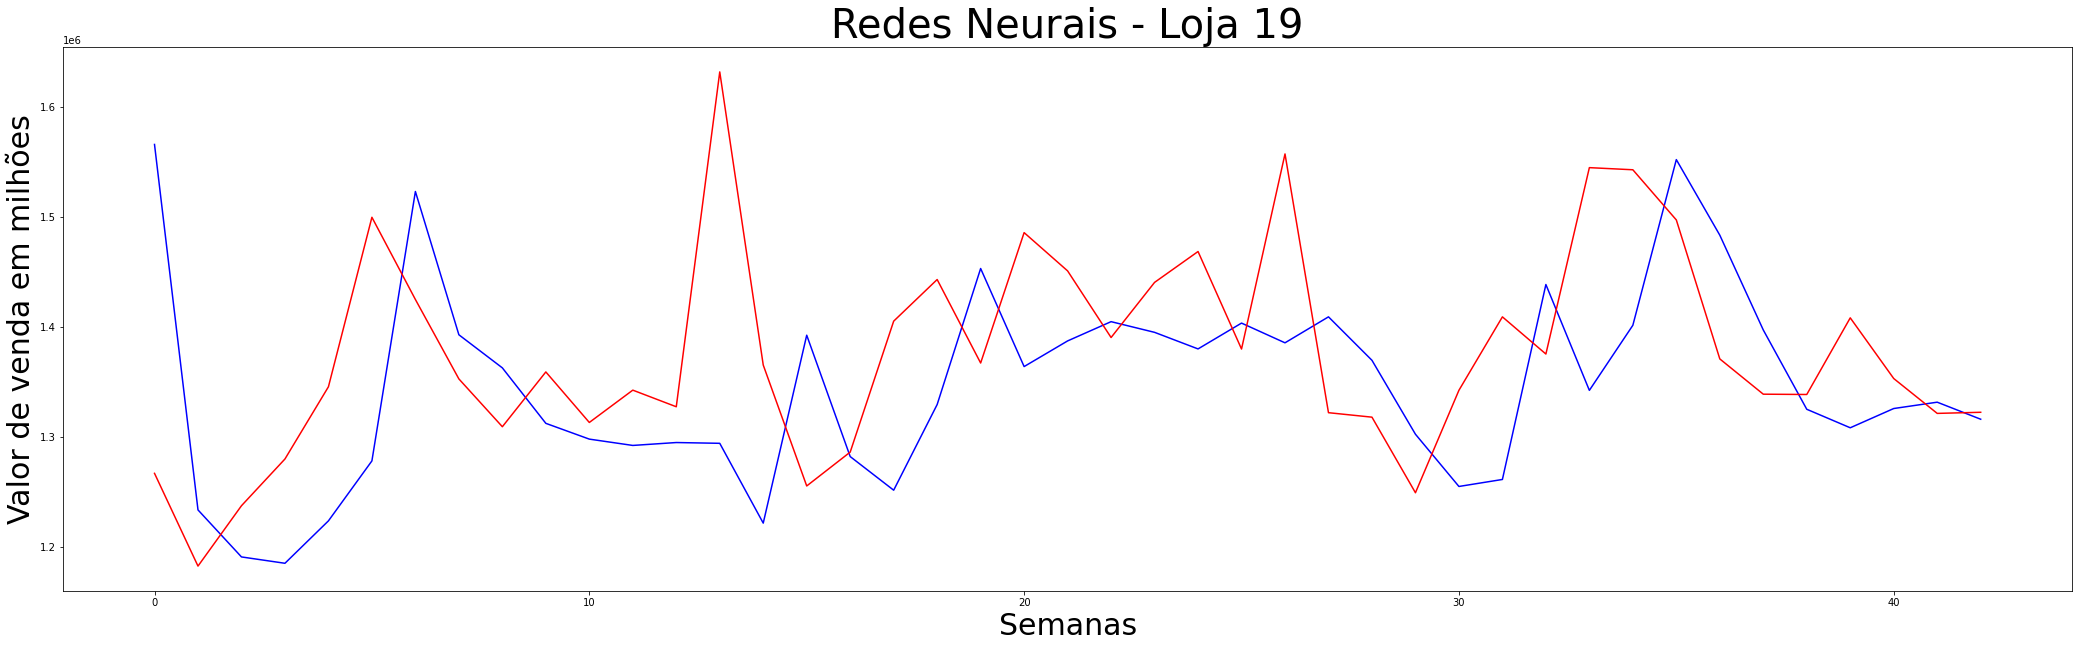

**************************************************
Resultados Loja 20:
-1.0963135434875246 154258.02 215927.81


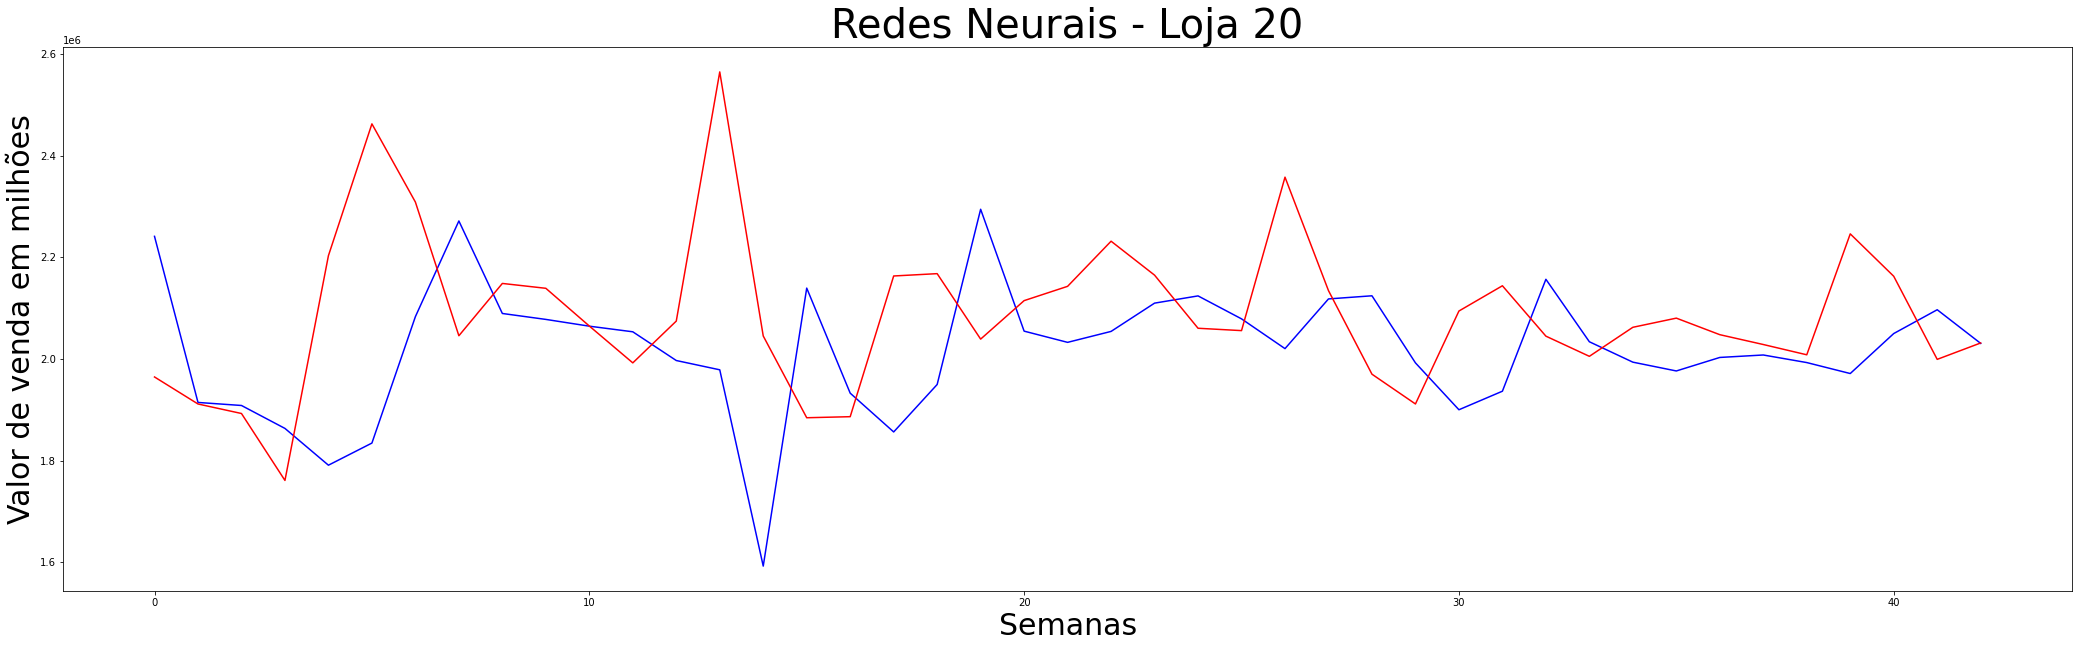

**************************************************
Resultados Loja 21:
-0.9492750657089695 45724.062 71433.63


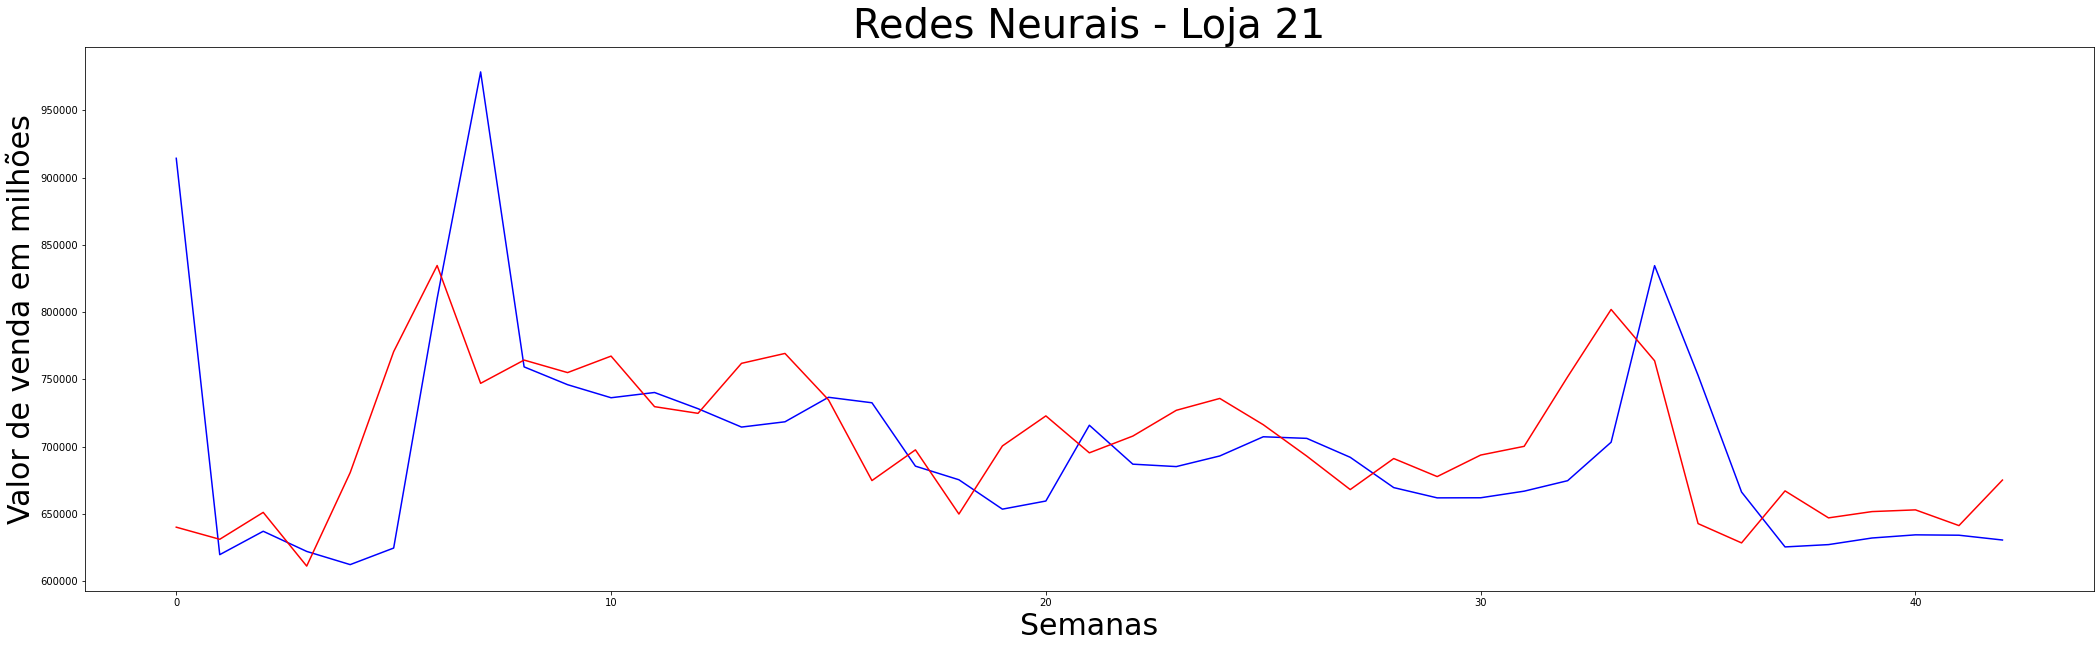

**************************************************
Resultados Loja 22:
-0.2757223366239552 62990.844 82209.93


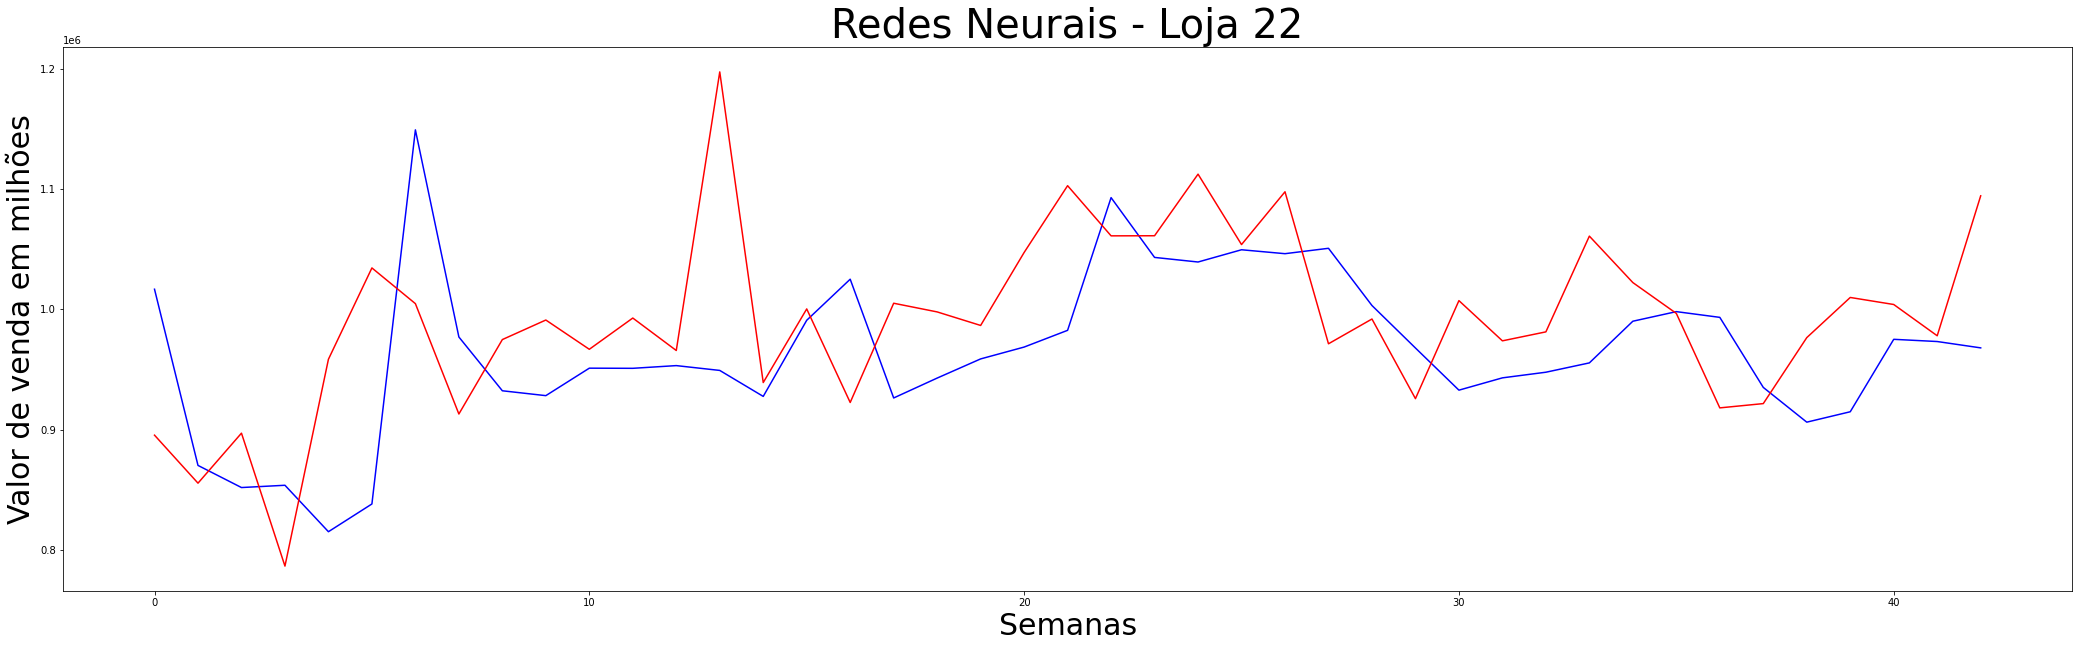

**************************************************
Resultados Loja 23:
0.23187677610281554 92989.414 124094.51


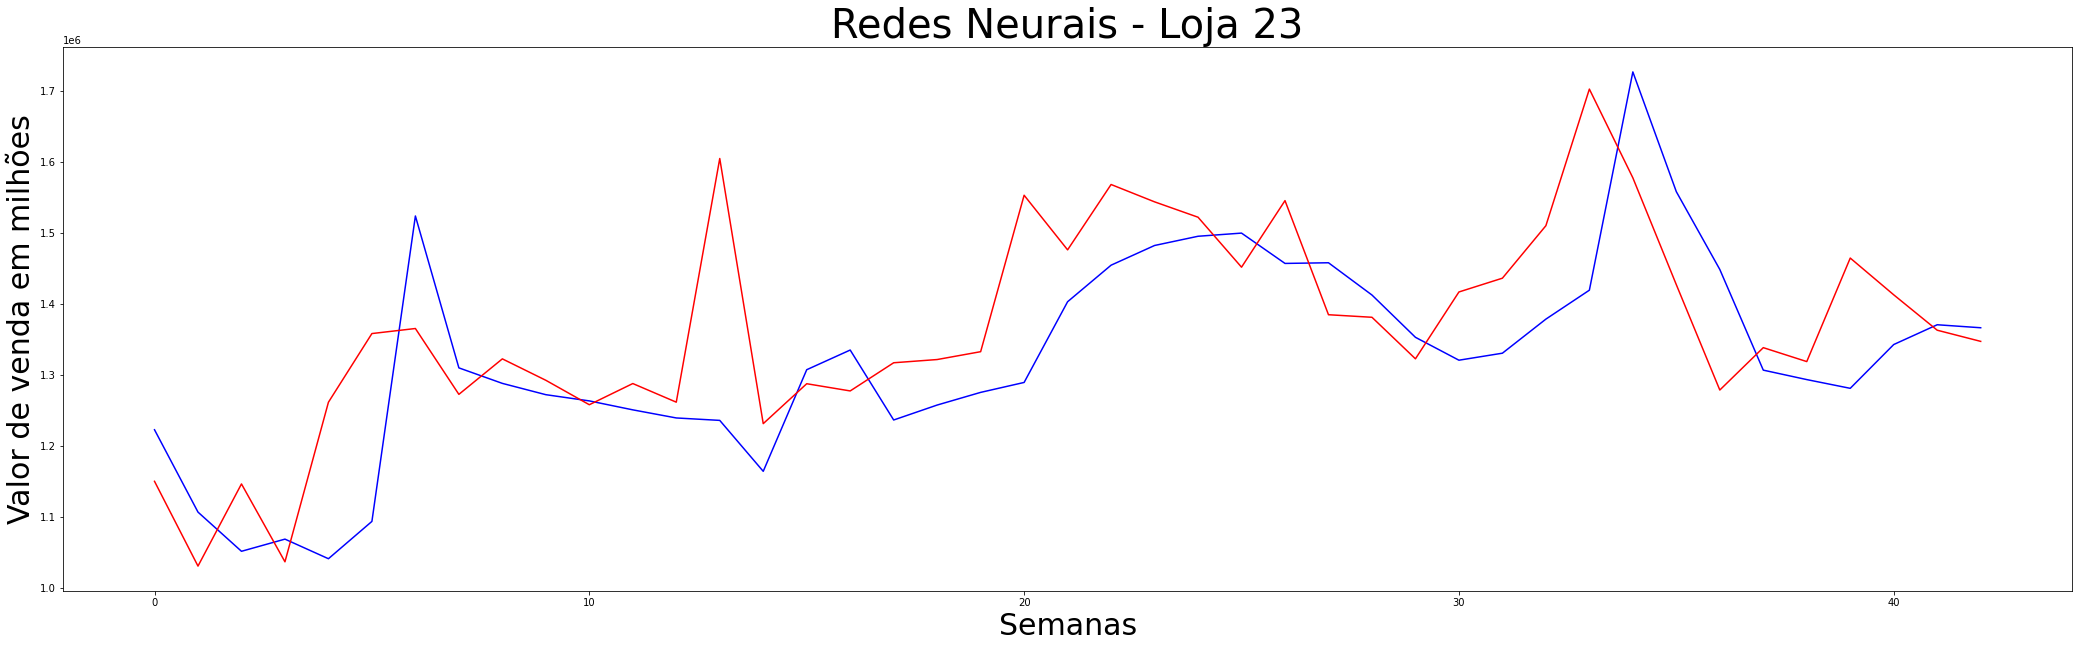

**************************************************
Resultados Loja 24:
-0.5790073789340364 110871.79 141055.22


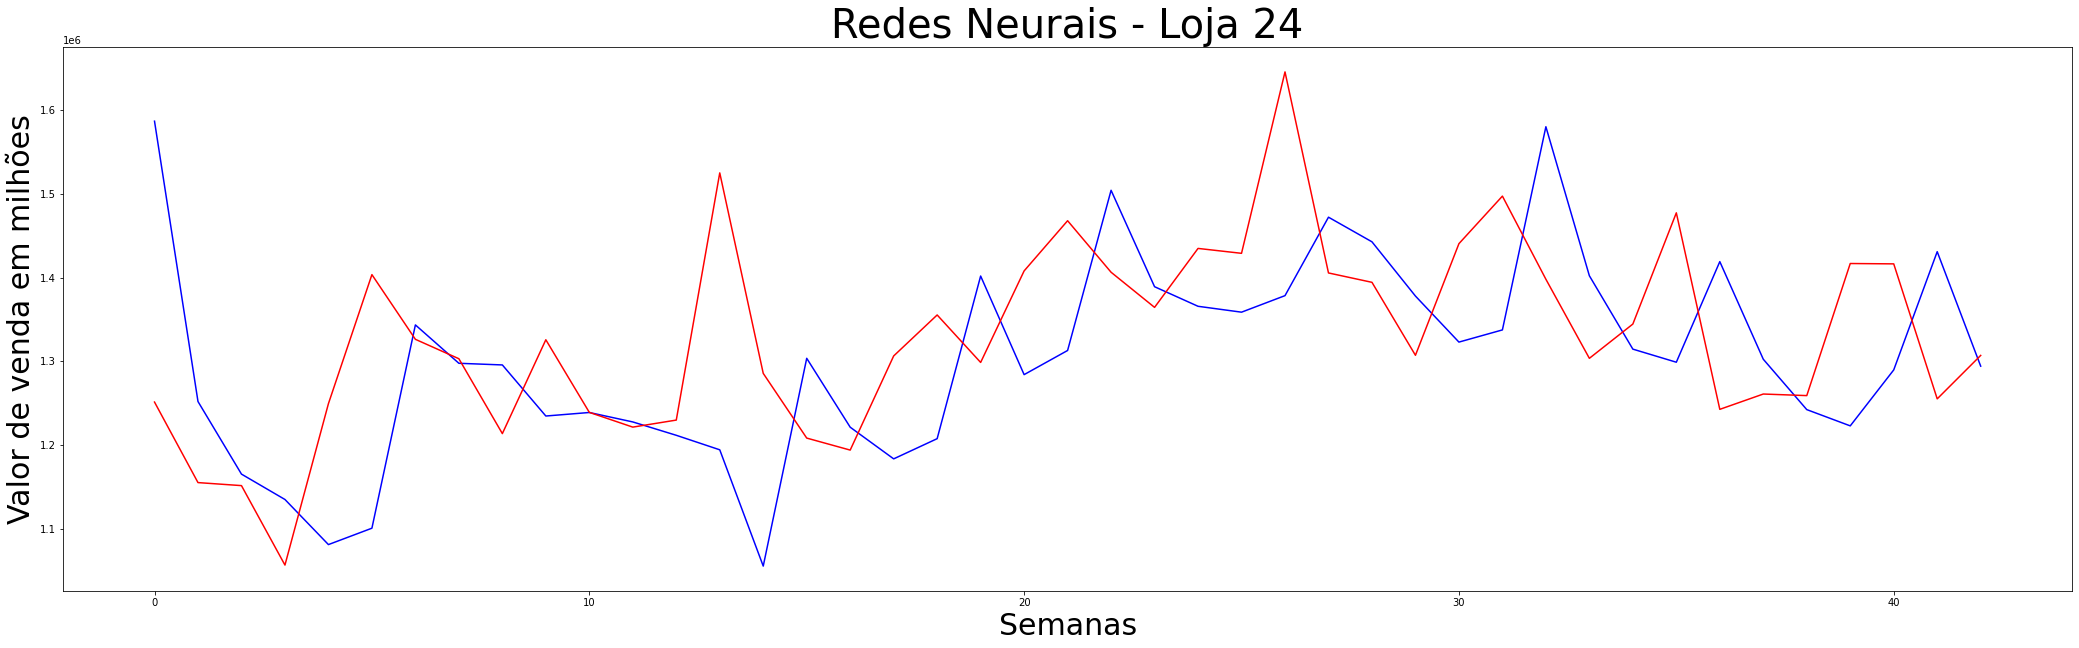

**************************************************
Resultados Loja 25:
0.03896054040303265 35617.156 45494.883


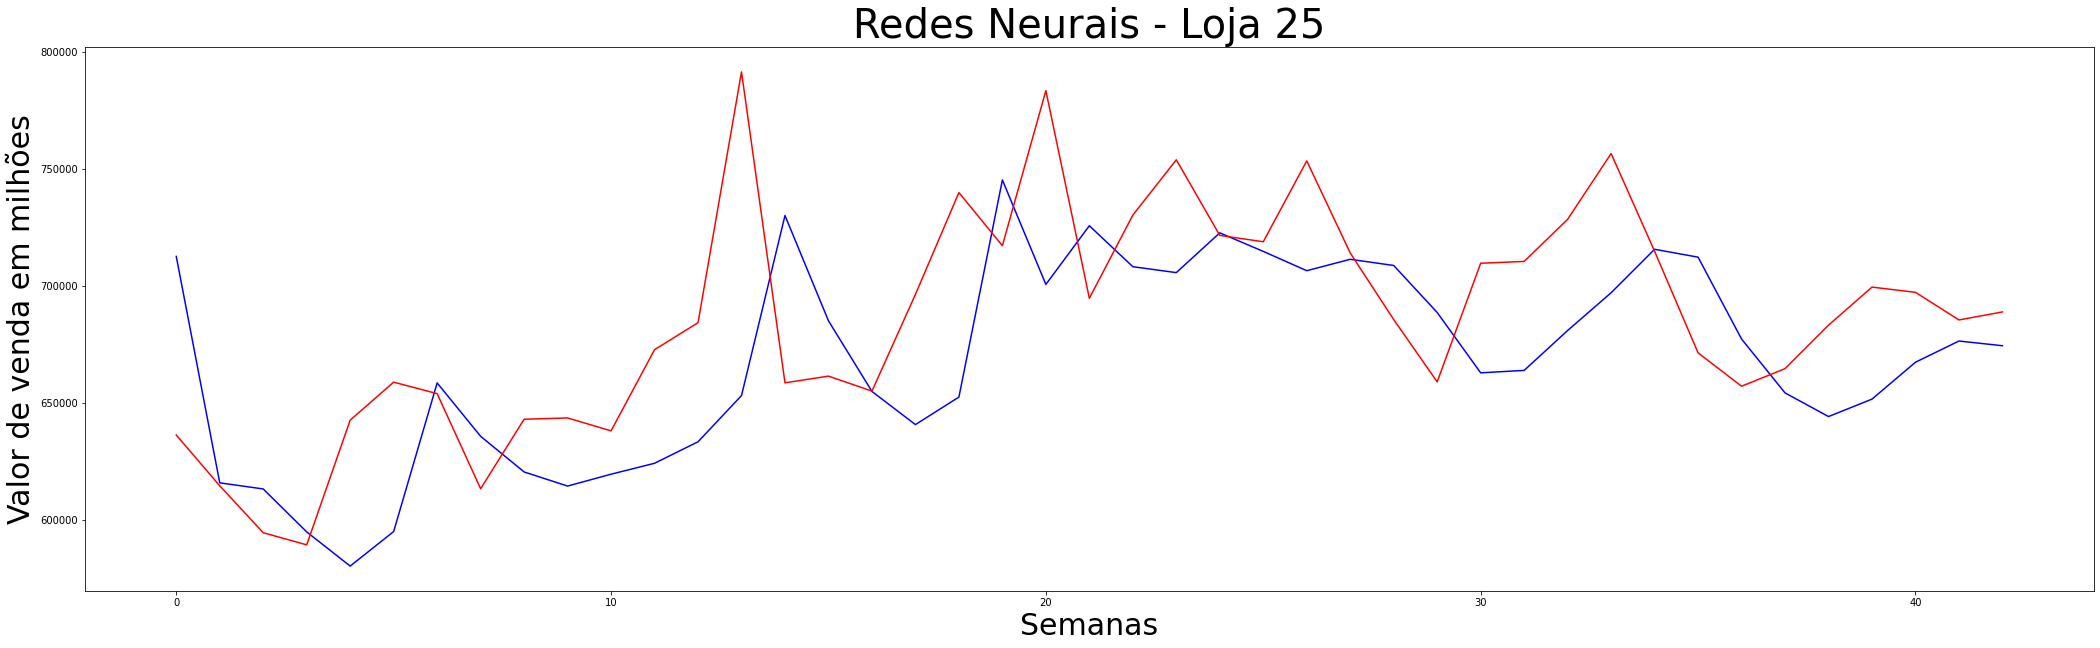

**************************************************
Resultados Loja 26:
-0.381684448800679 73570.0 97966.61


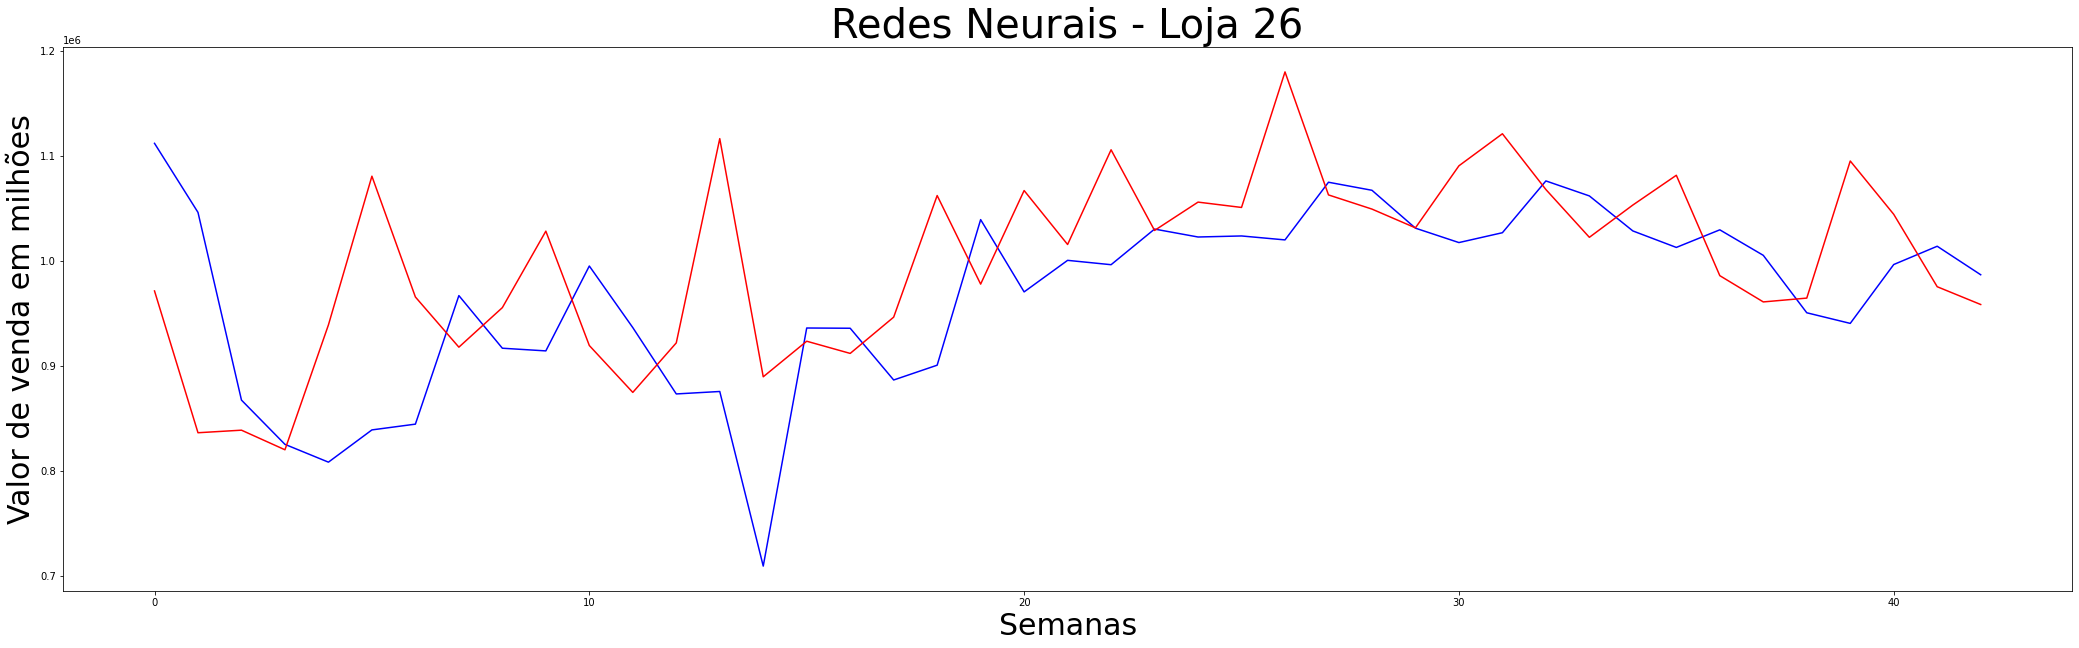

**************************************************
Resultados Loja 27:
-0.09400130479634328 114943.51 141266.39


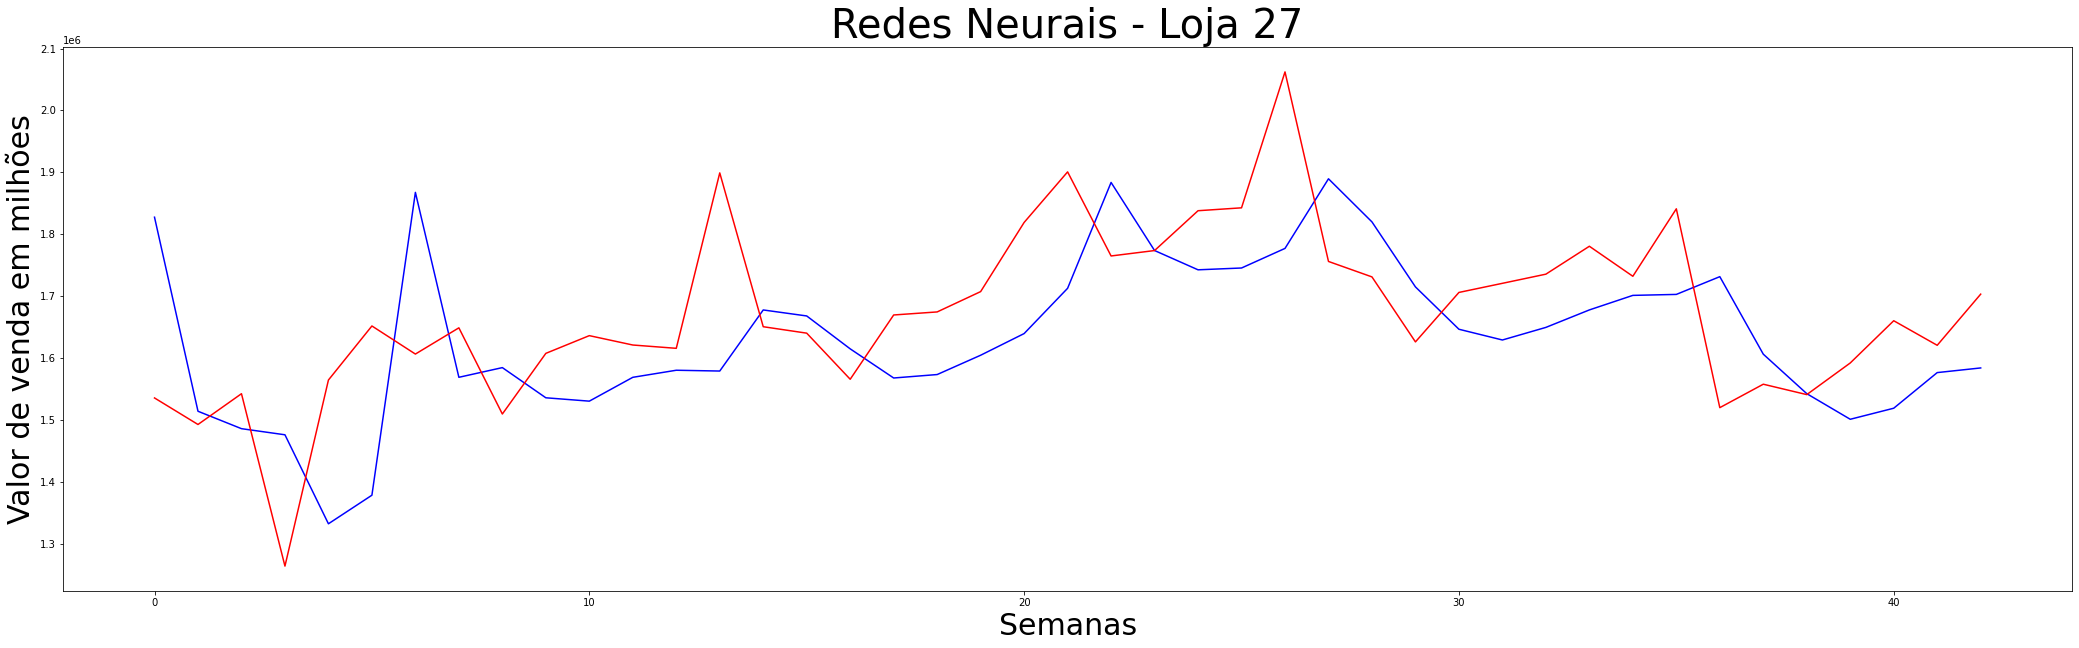

**************************************************
Resultados Loja 28:
-0.8664038029551575 159271.78 208002.52


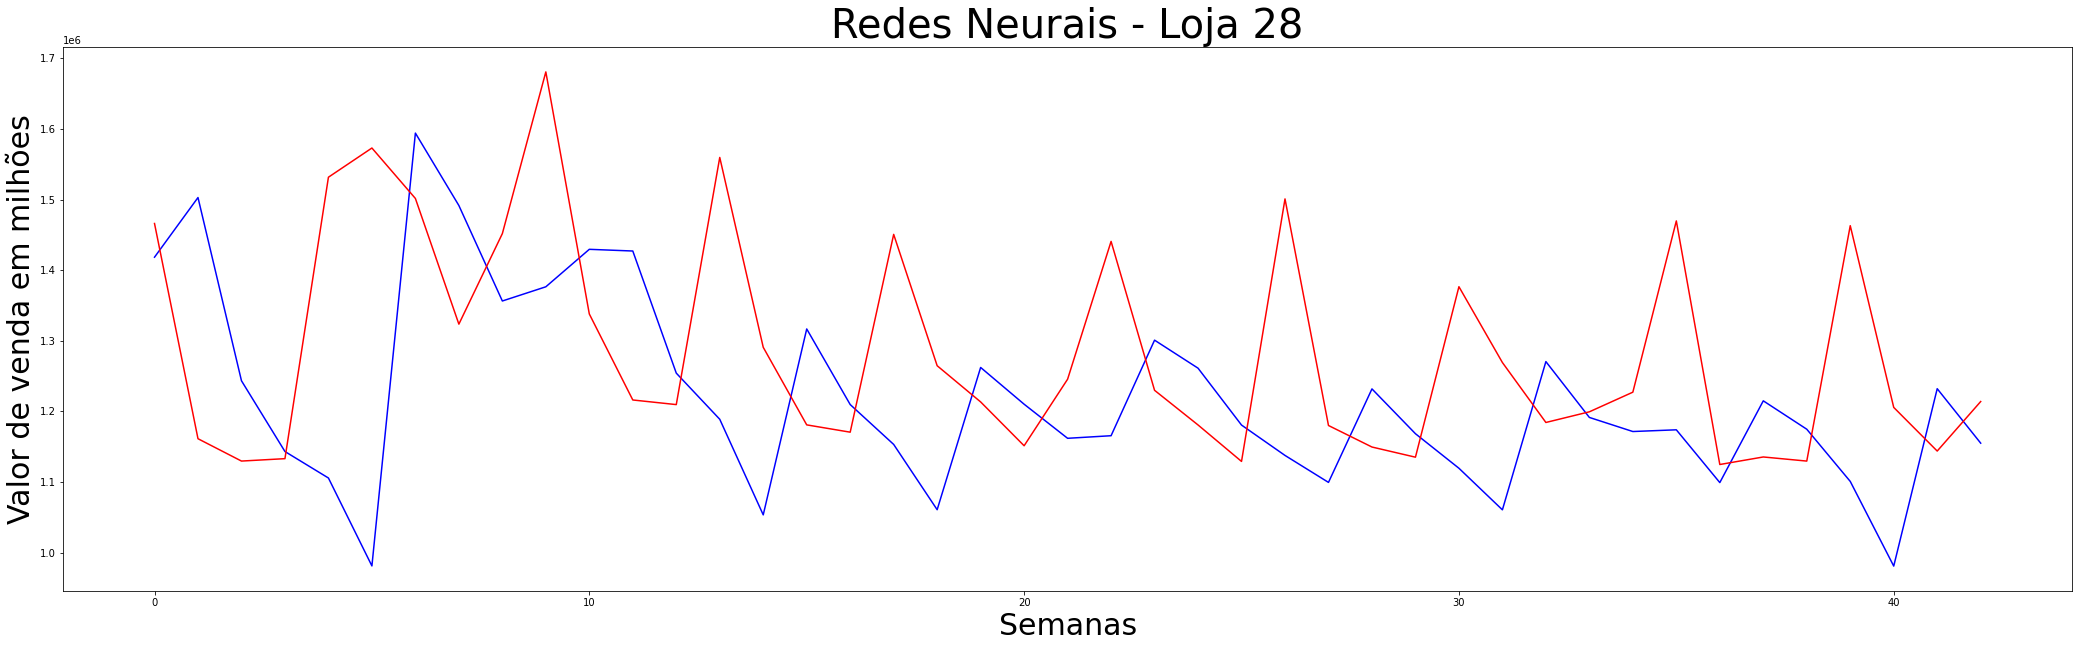

**************************************************
Resultados Loja 29:
-0.5646899956246194 41296.06 57517.13


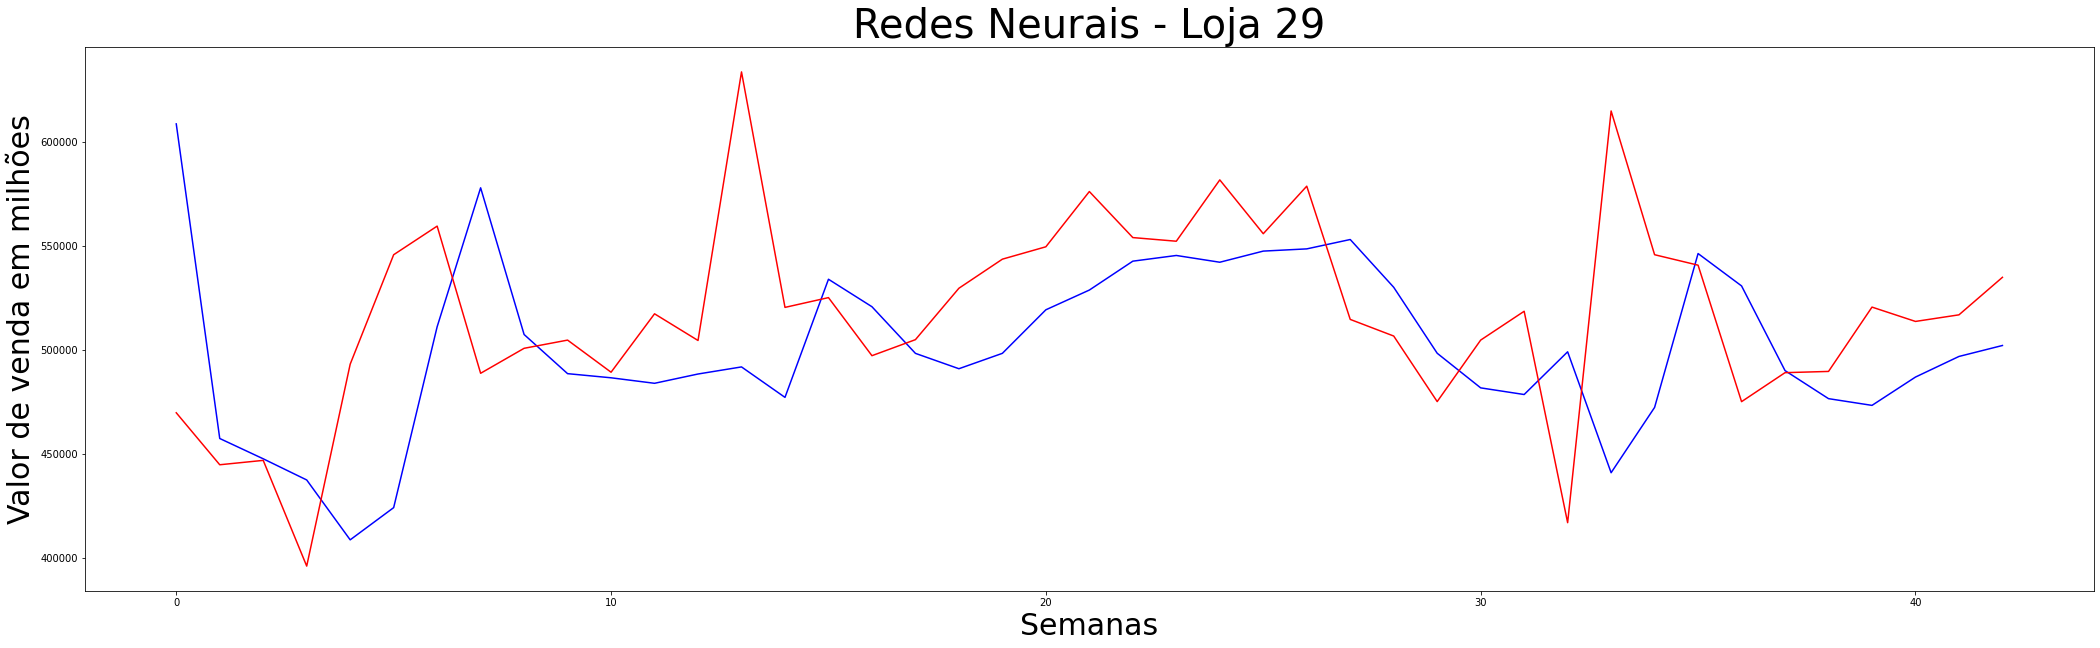

**************************************************
Resultados Loja 30:
-2.11155182061951 16372.096 20679.793


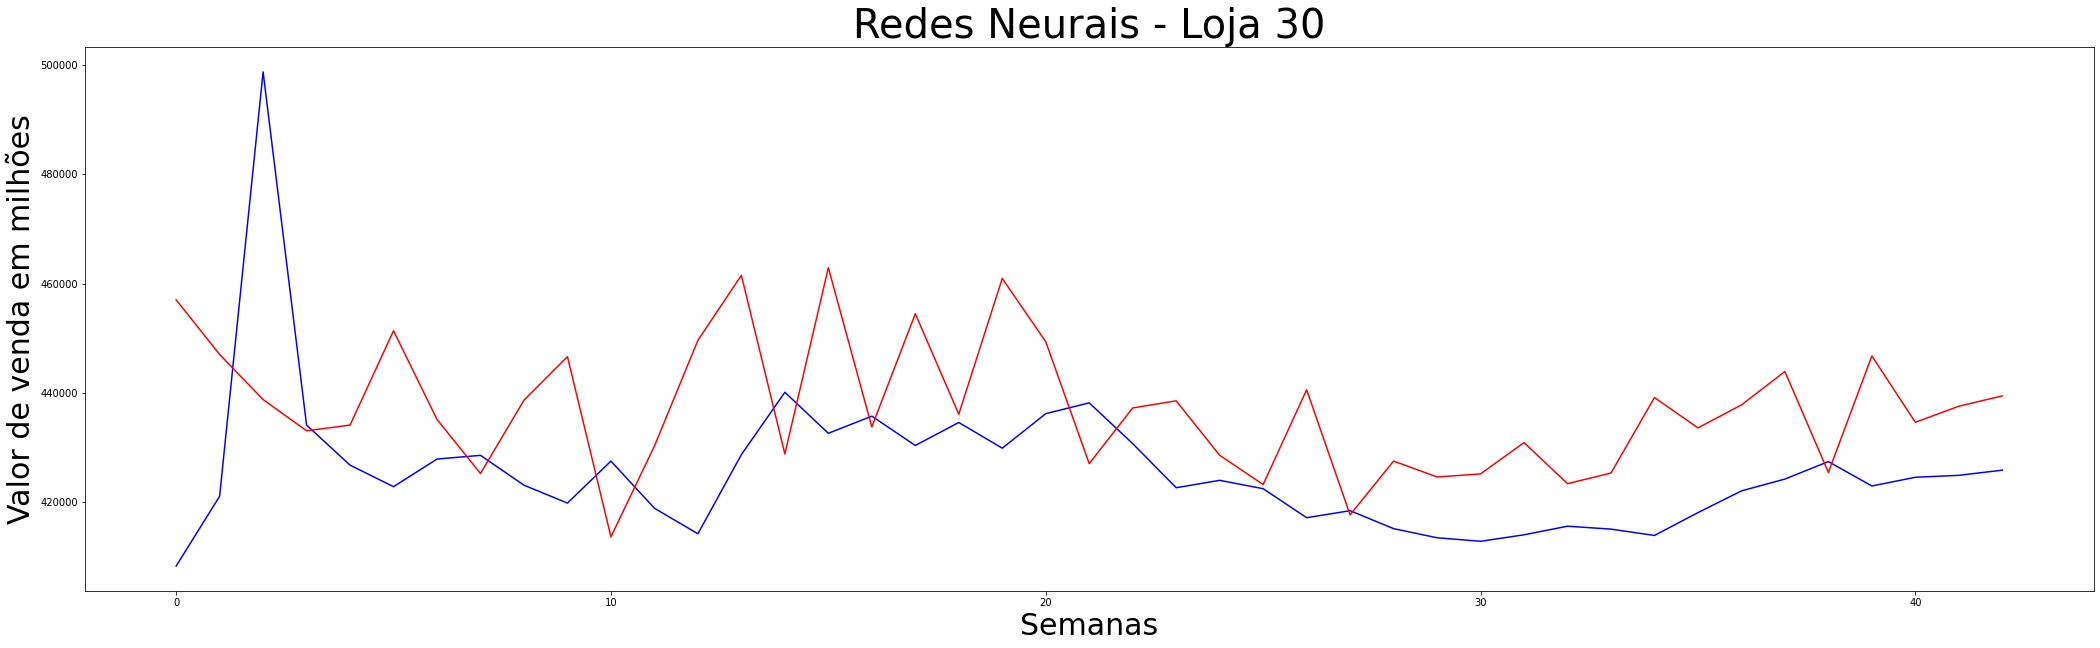

**************************************************
Resultados Loja 31:
-1.3490562310687326 70392.58 89914.31


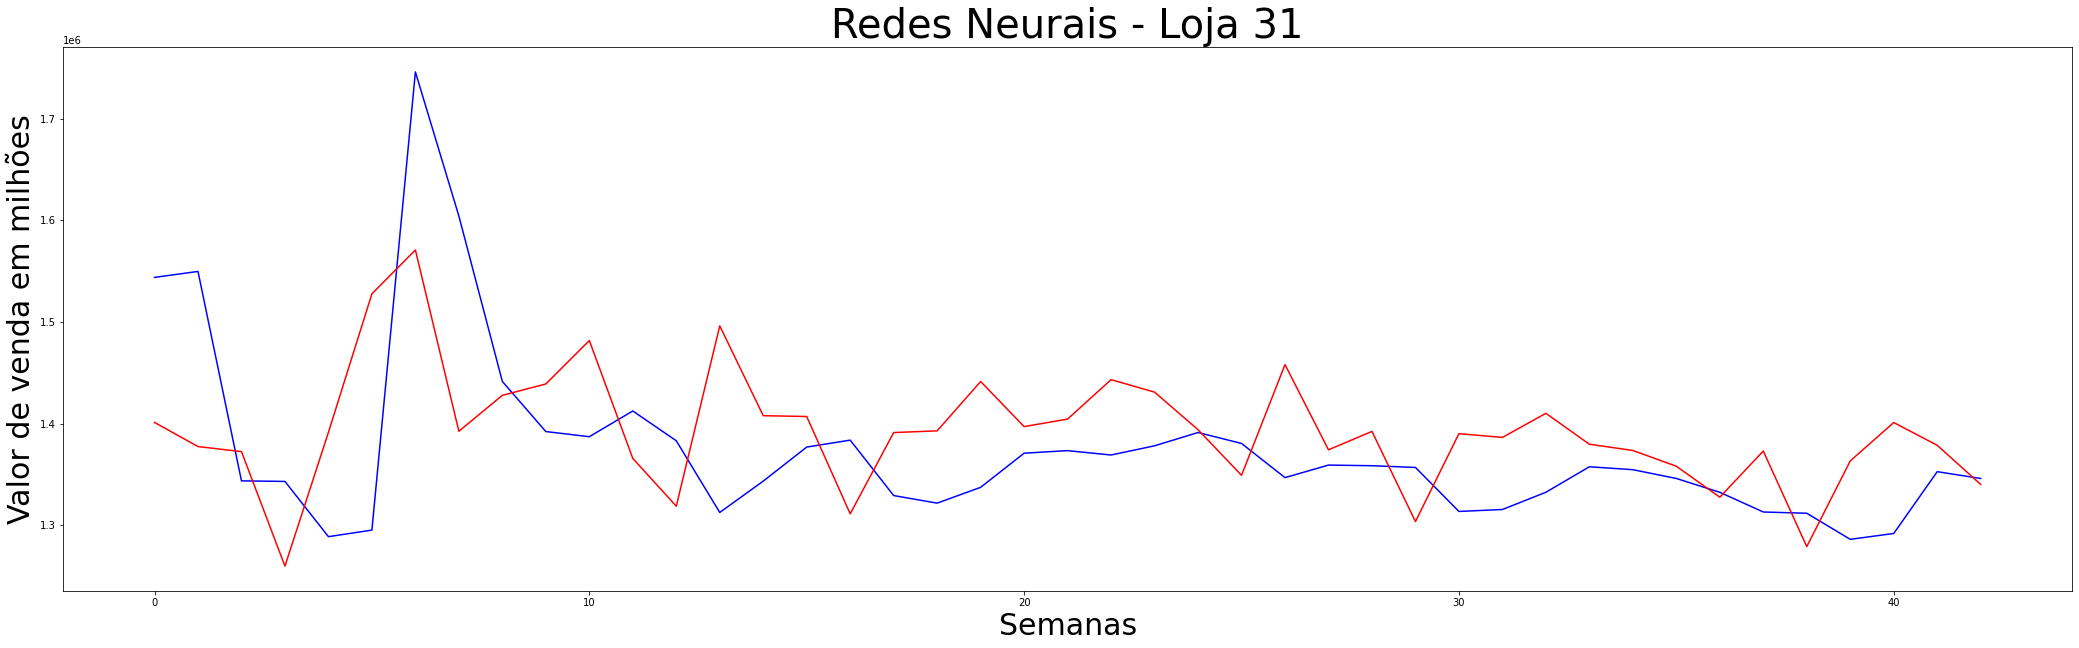

**************************************************
Resultados Loja 32:
-0.4630027750934105 51374.766 64000.19


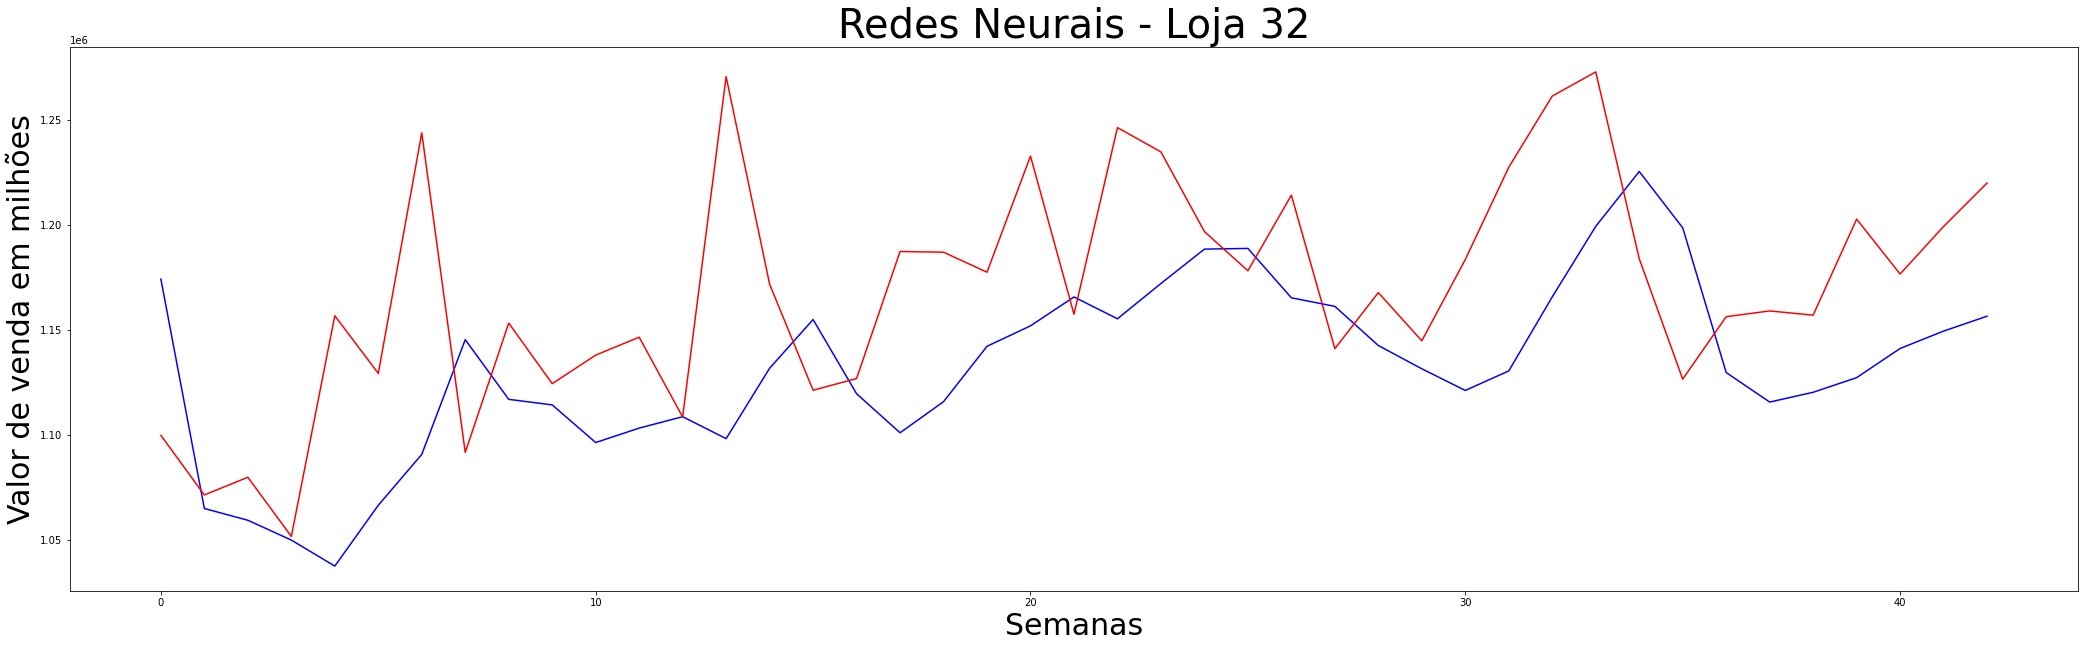

**************************************************
Resultados Loja 33:
-3.0526398922412934 31651.756 36873.62


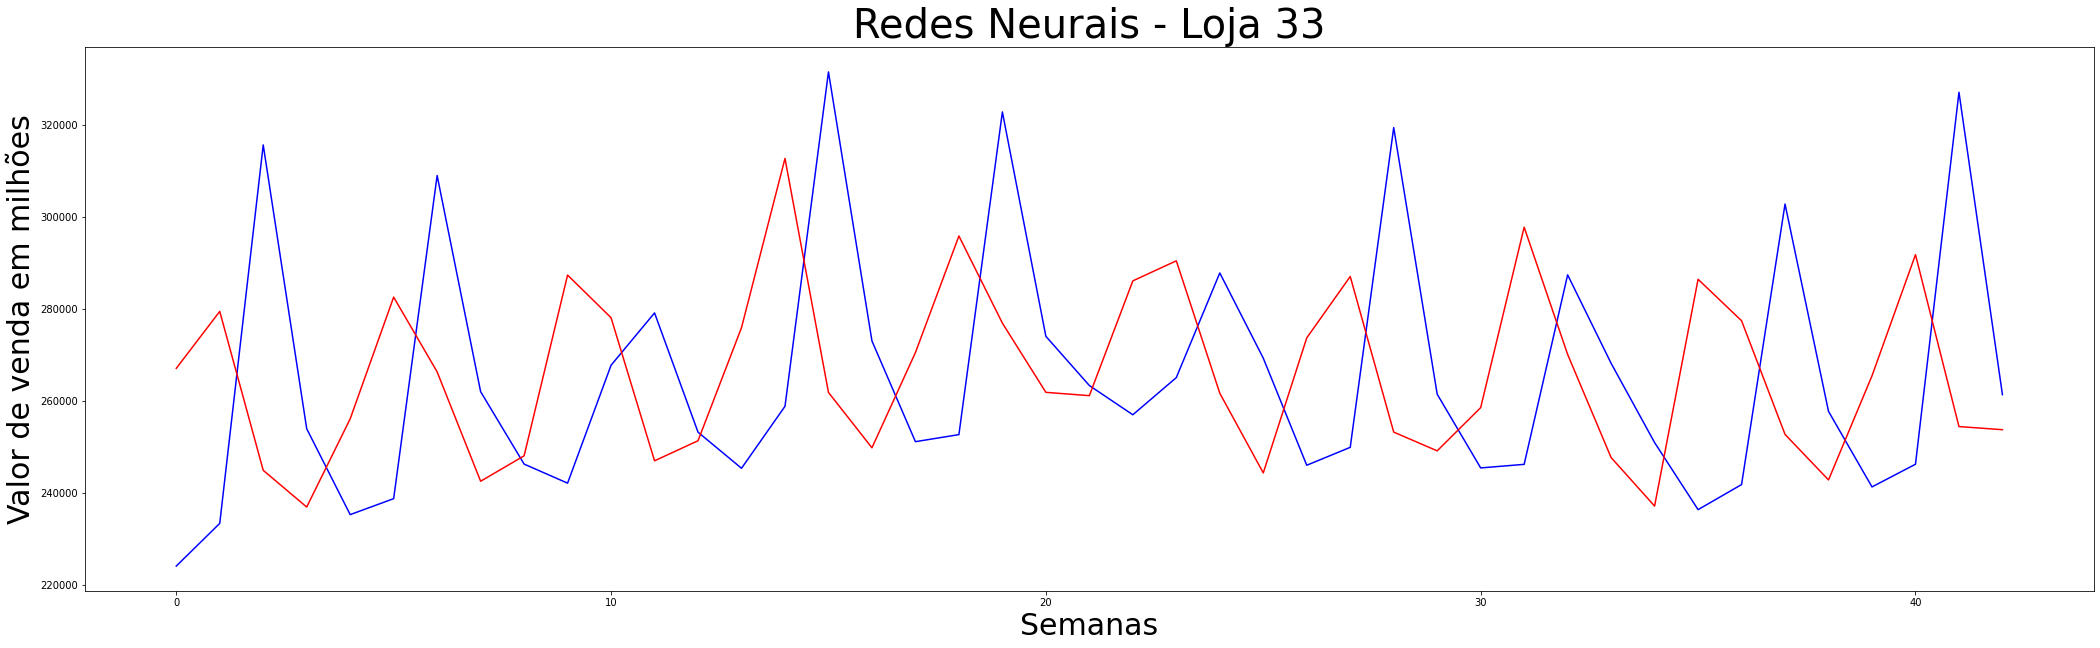

**************************************************
Resultados Loja 34:
-1.9715532541251504 47630.203 77578.04


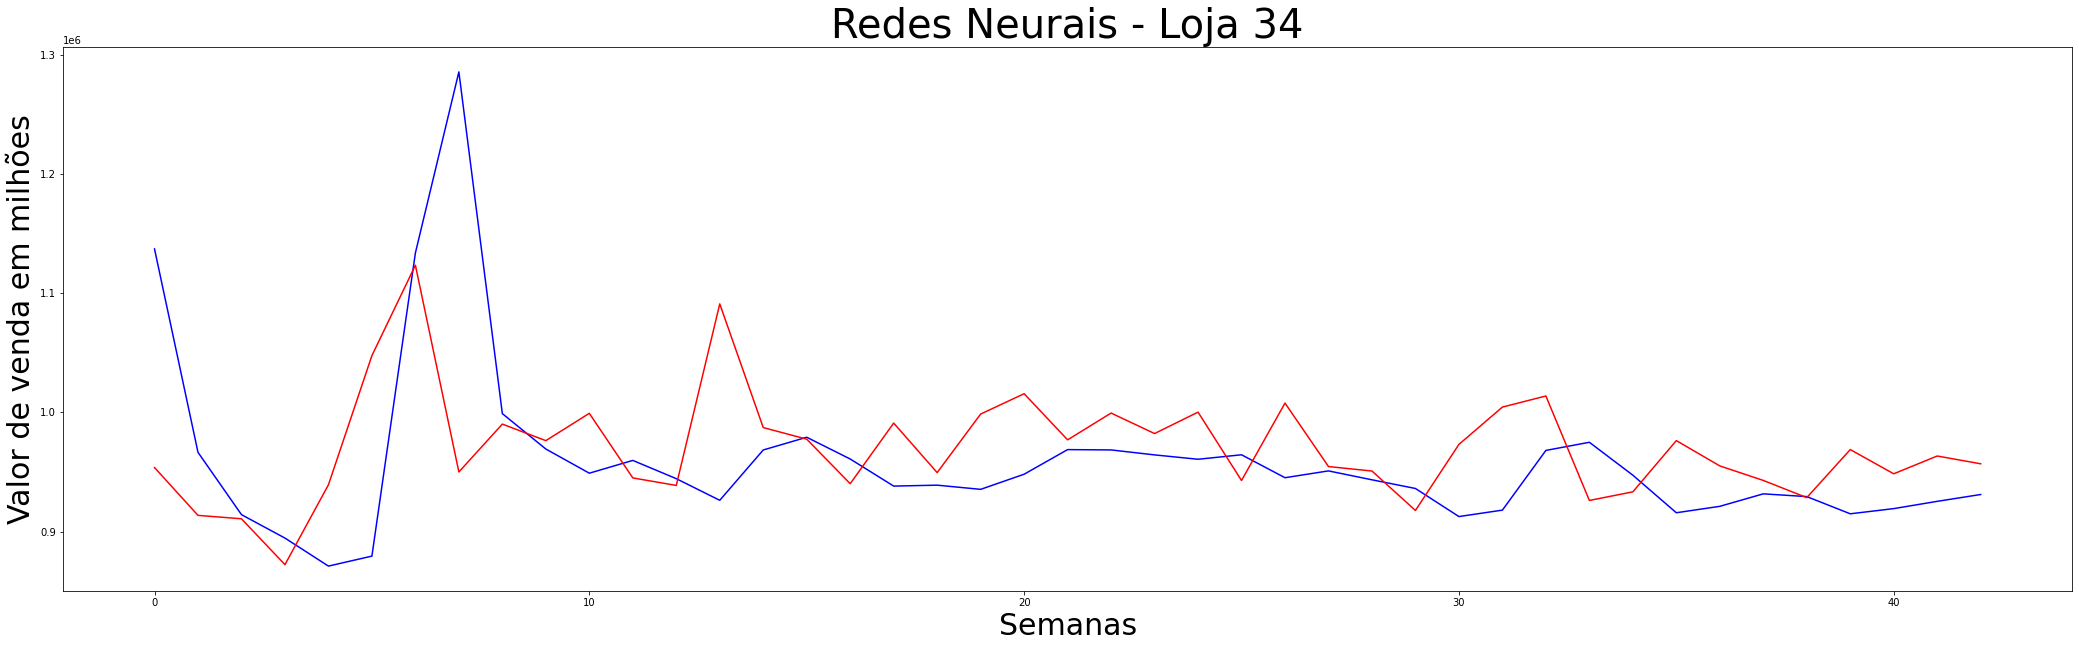

**************************************************
Resultados Loja 35:
-0.4119659915956053 66571.09 98486.516


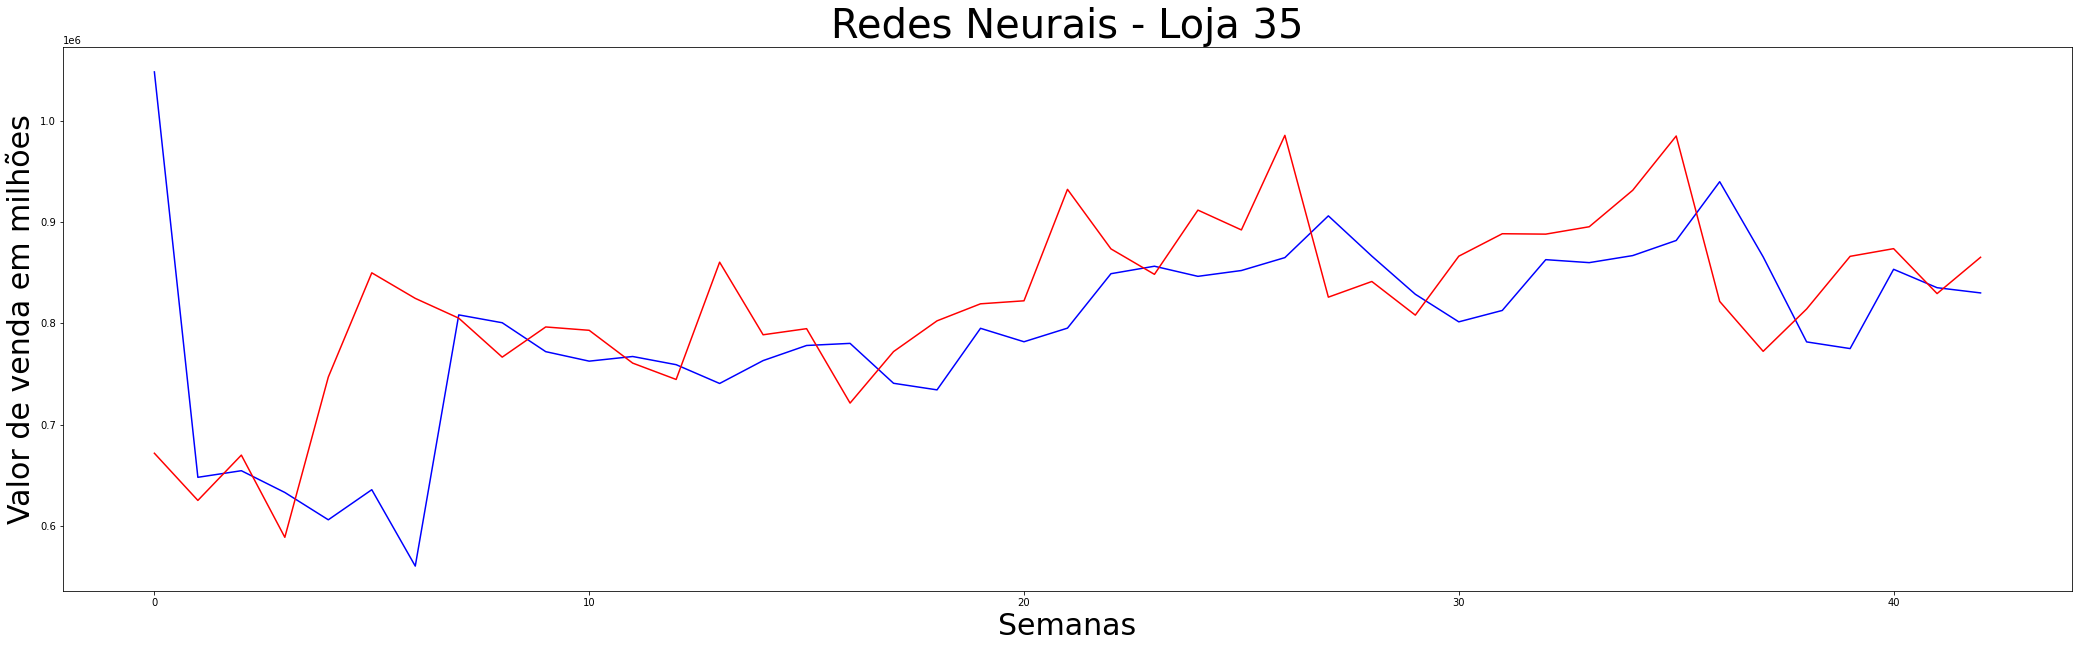

**************************************************
Resultados Loja 36:
0.03863229959208969 15169.2705 18173.809


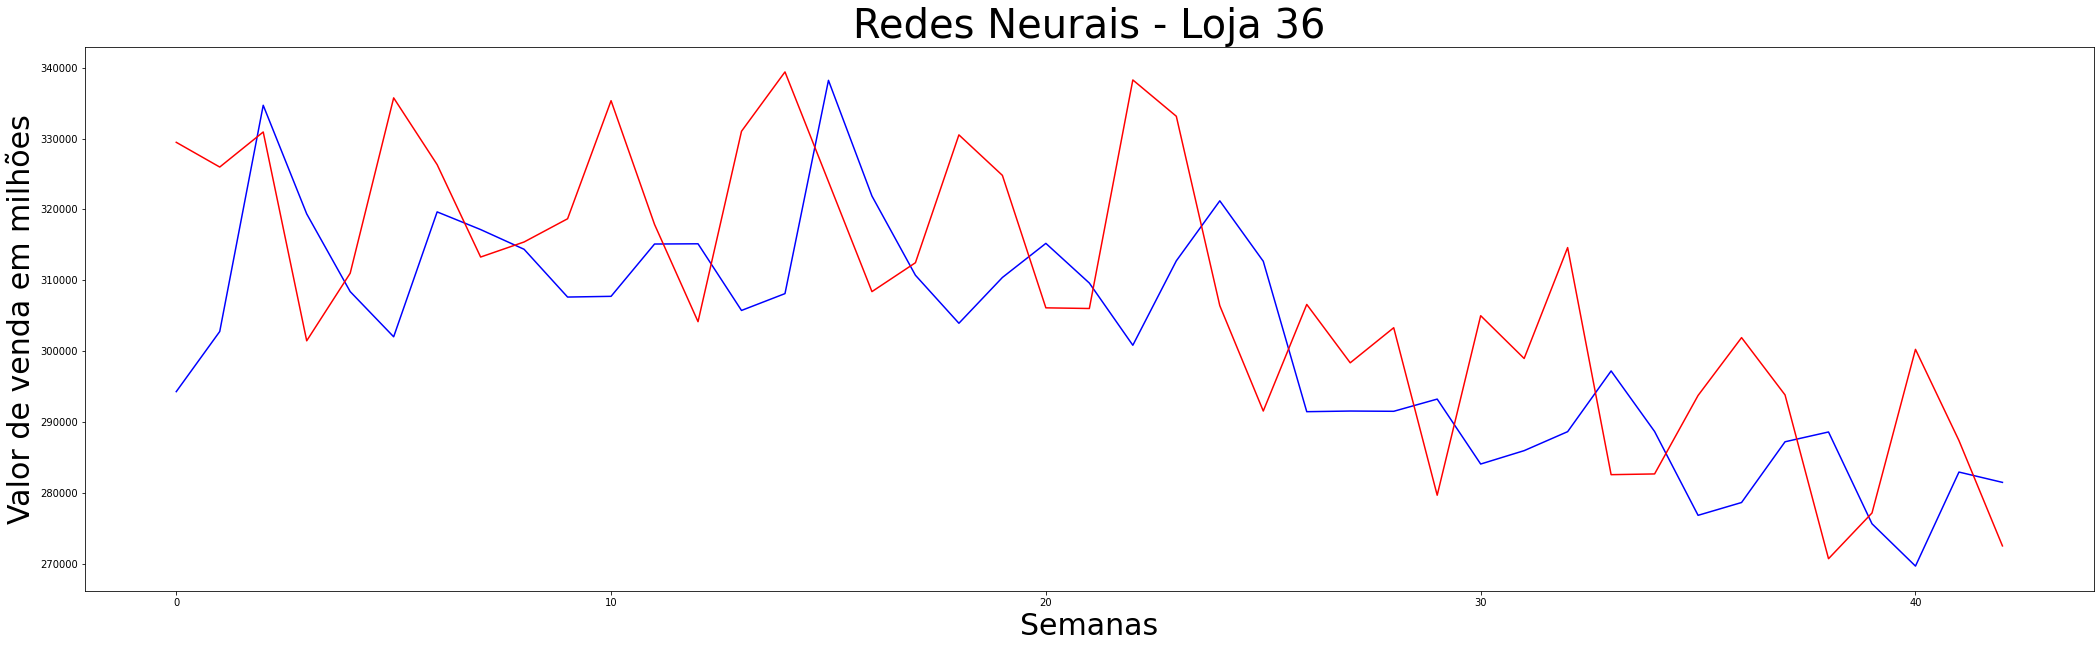

**************************************************
Resultados Loja 37:
-1.3707797107891357 22188.264 26899.838


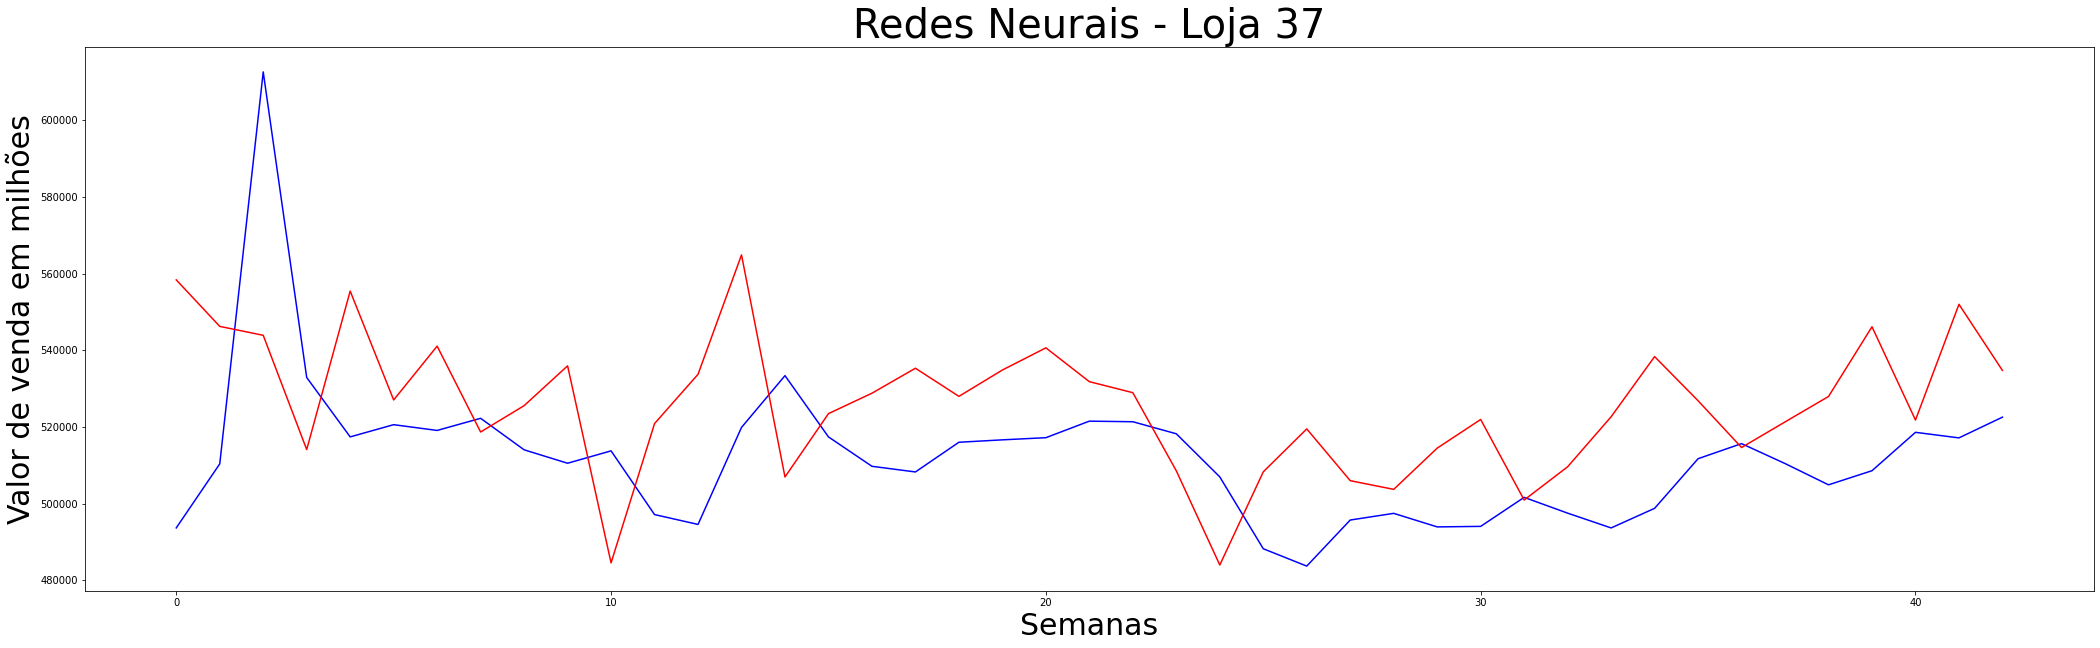

**************************************************
Resultados Loja 38:
-1.6726787958748952 34286.05 44538.82


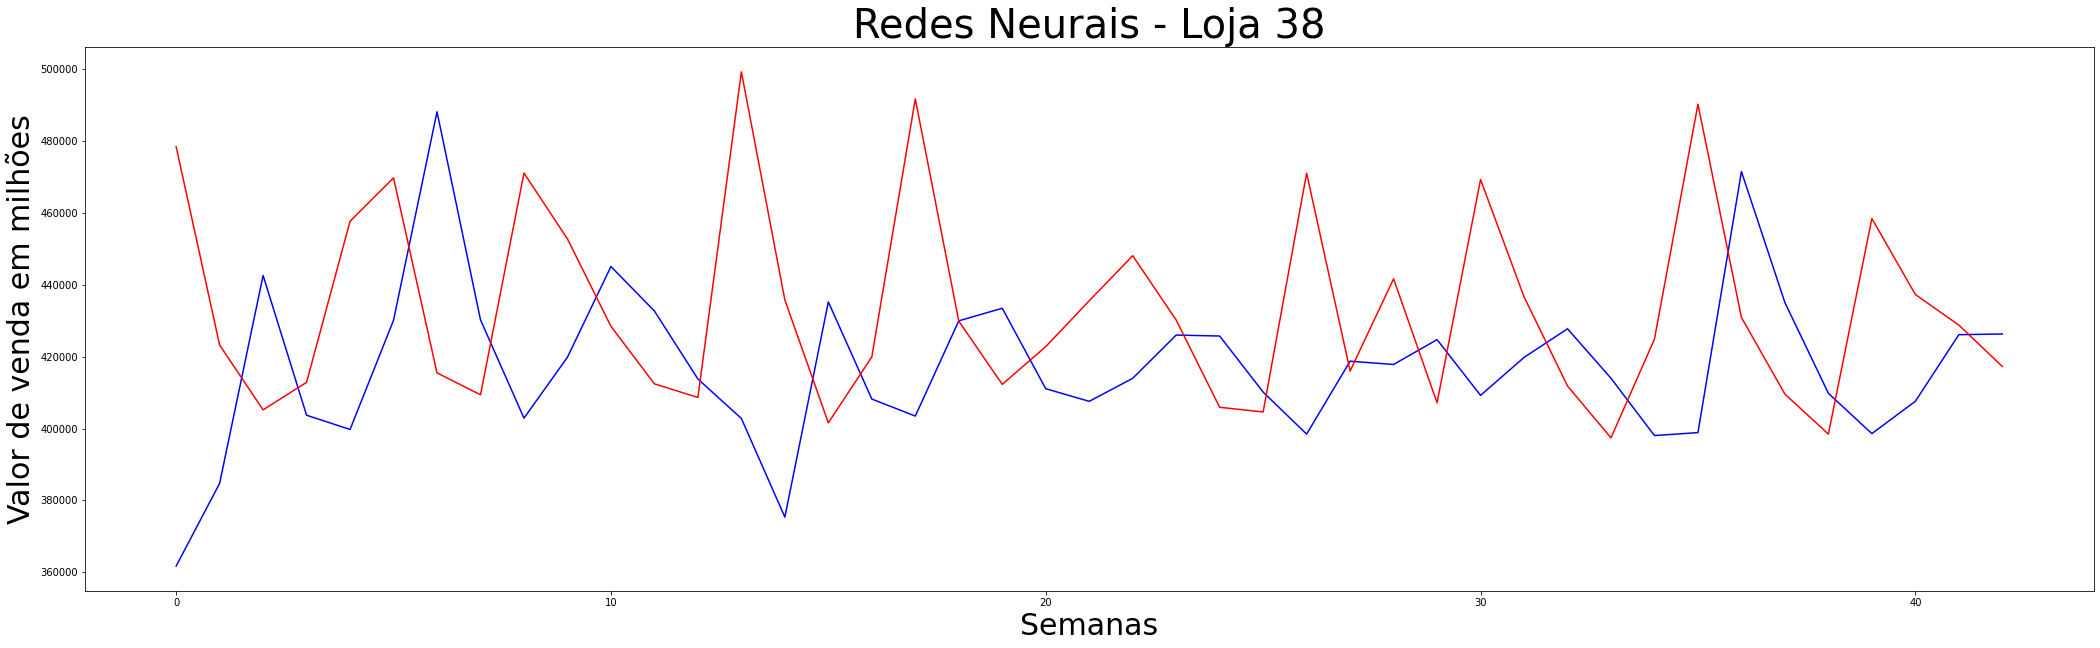

**************************************************
Resultados Loja 39:
-0.13639519986332505 84022.91 105706.875


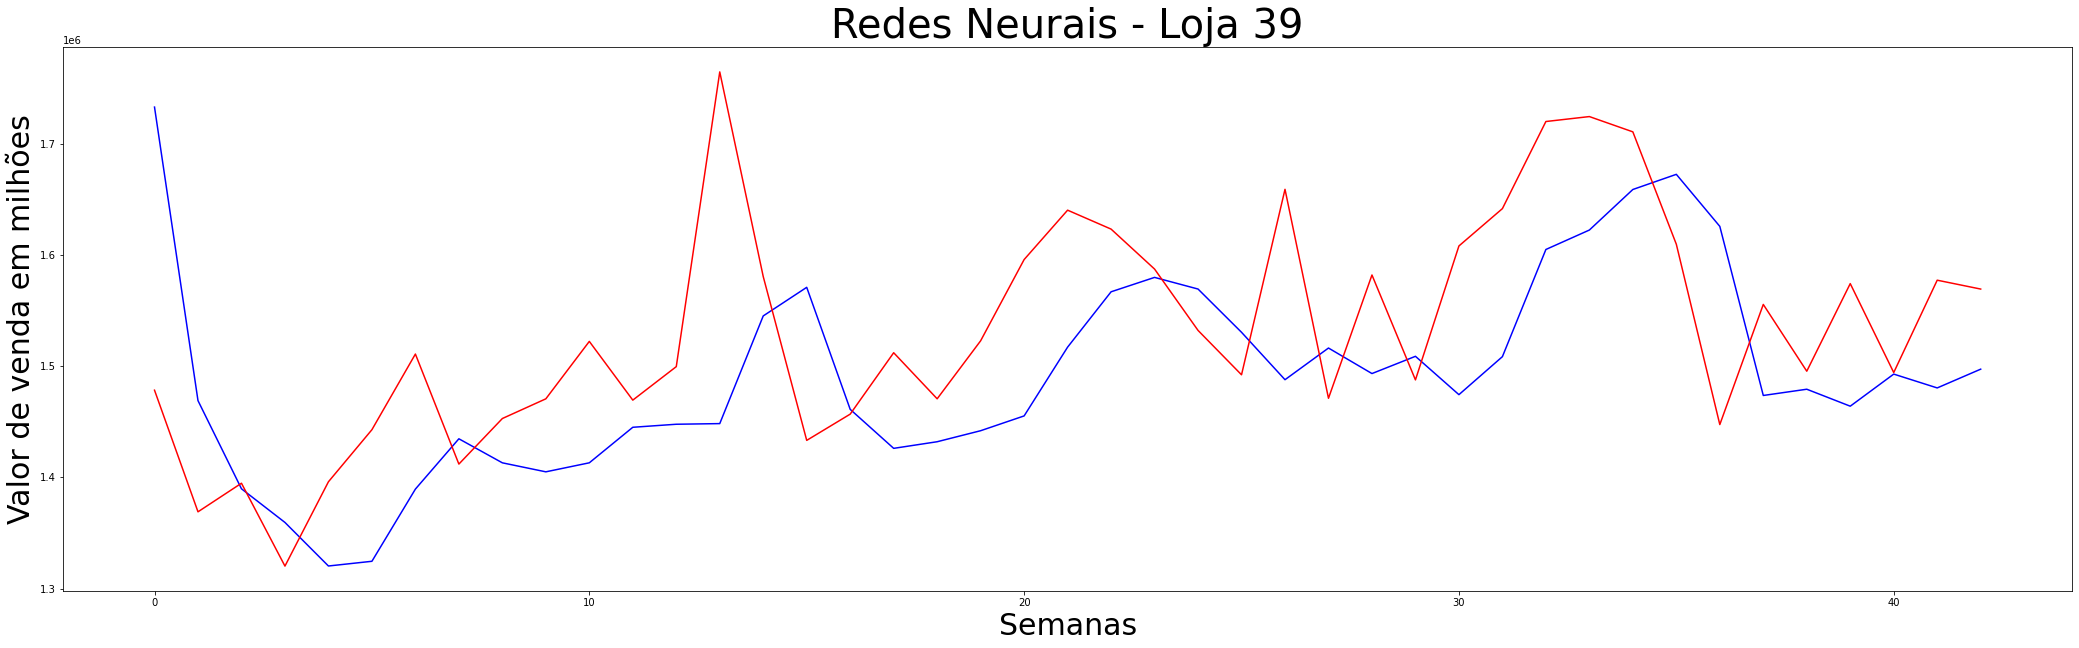

**************************************************
Resultados Loja 40:
-0.5986311209264756 79056.51 107539.08


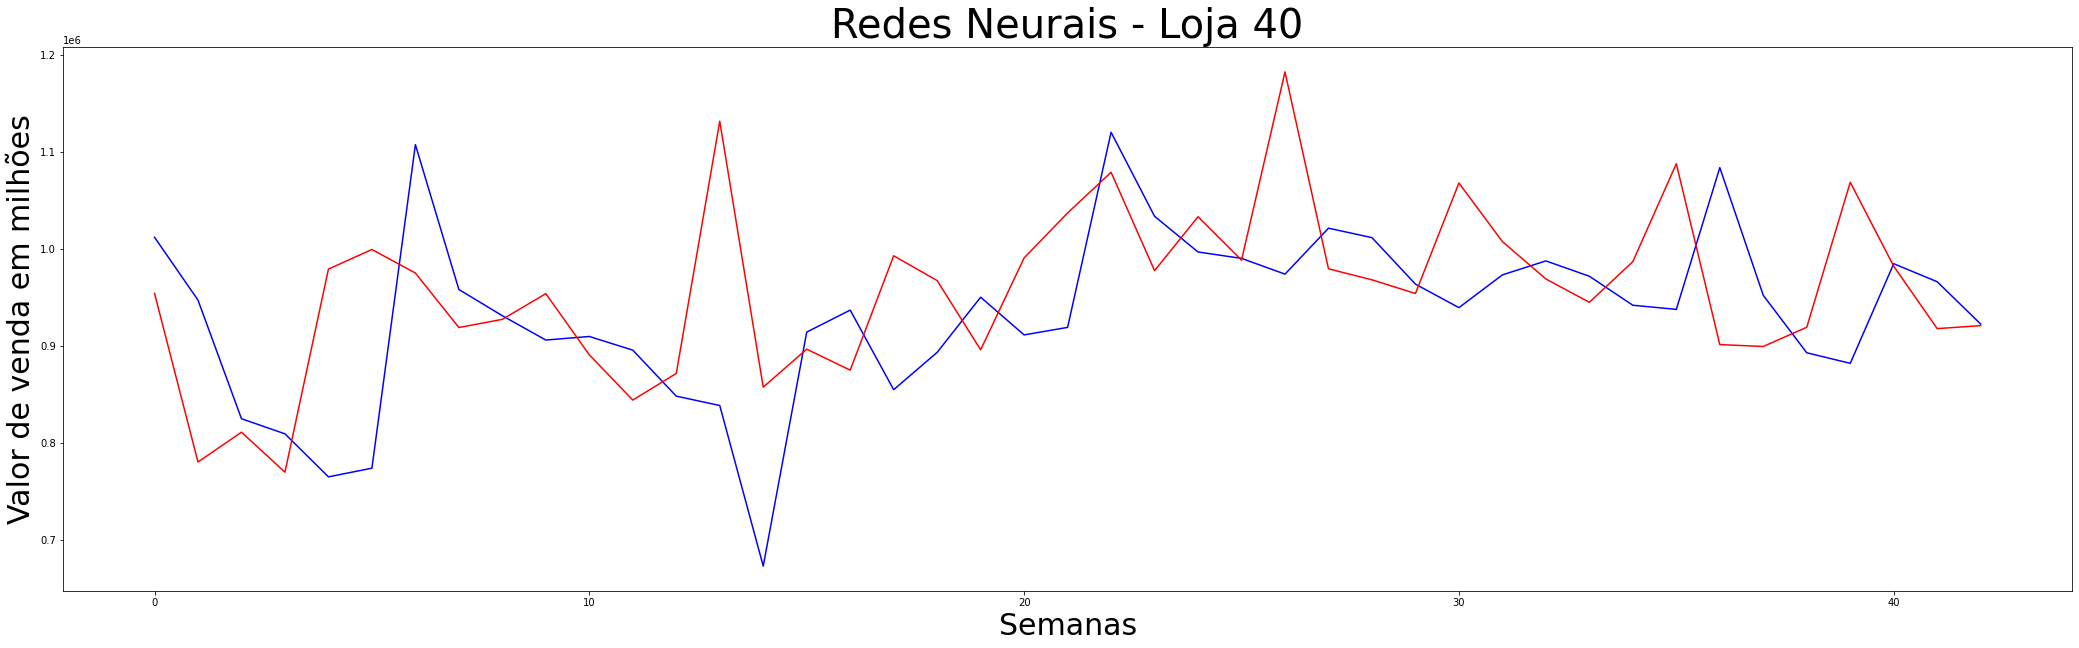

**************************************************
Resultados Loja 41:
0.29303729333538664 64301.254 87256.26


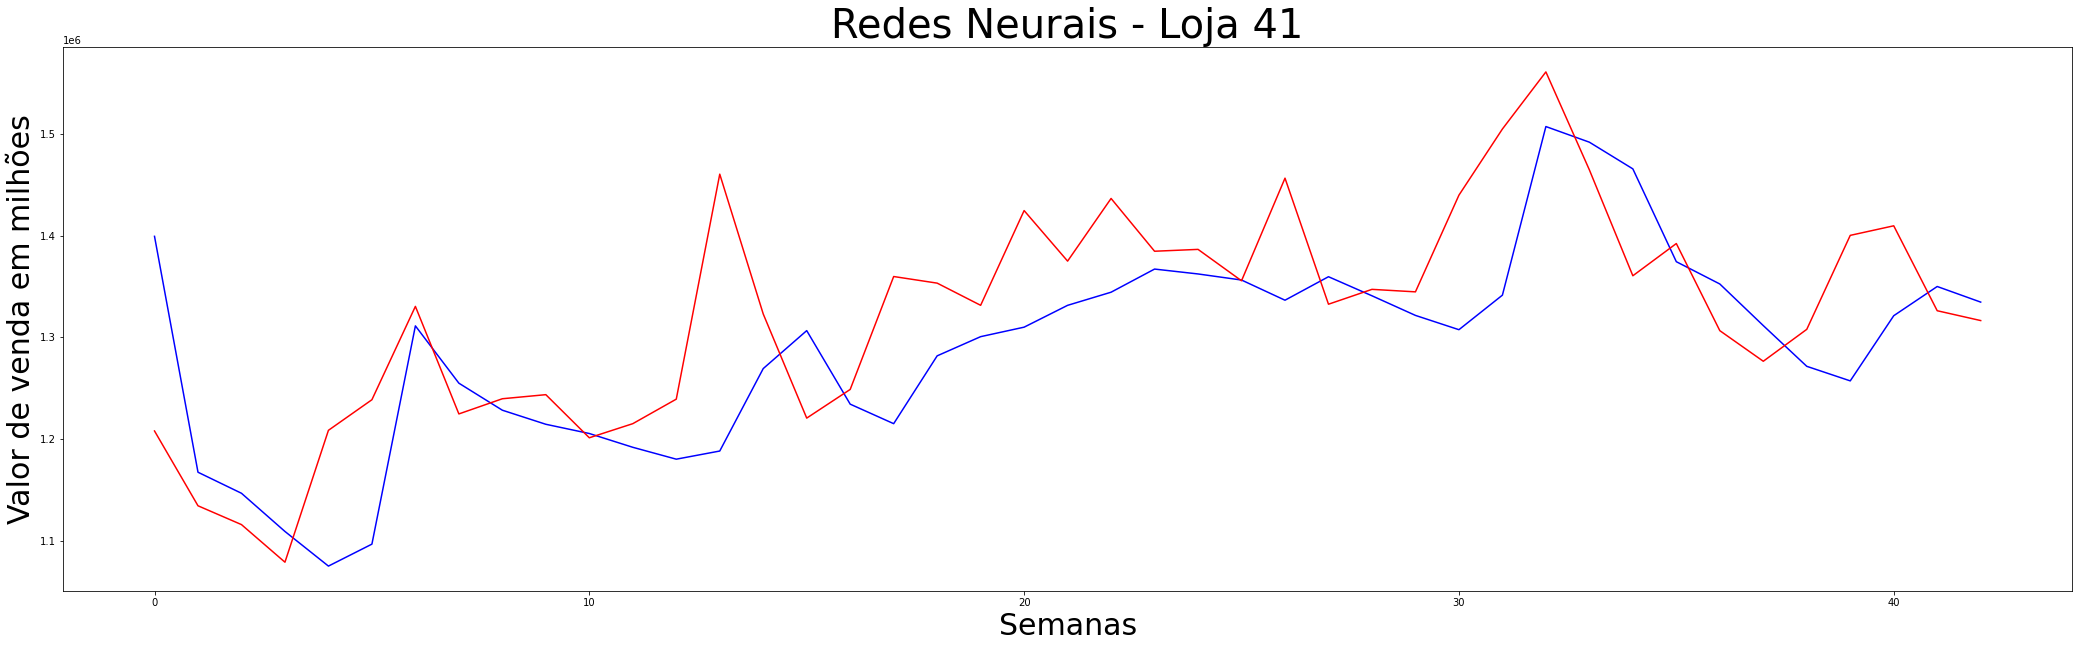

**************************************************
Resultados Loja 42:
-2.5852156665540234 78777.625 91504.28


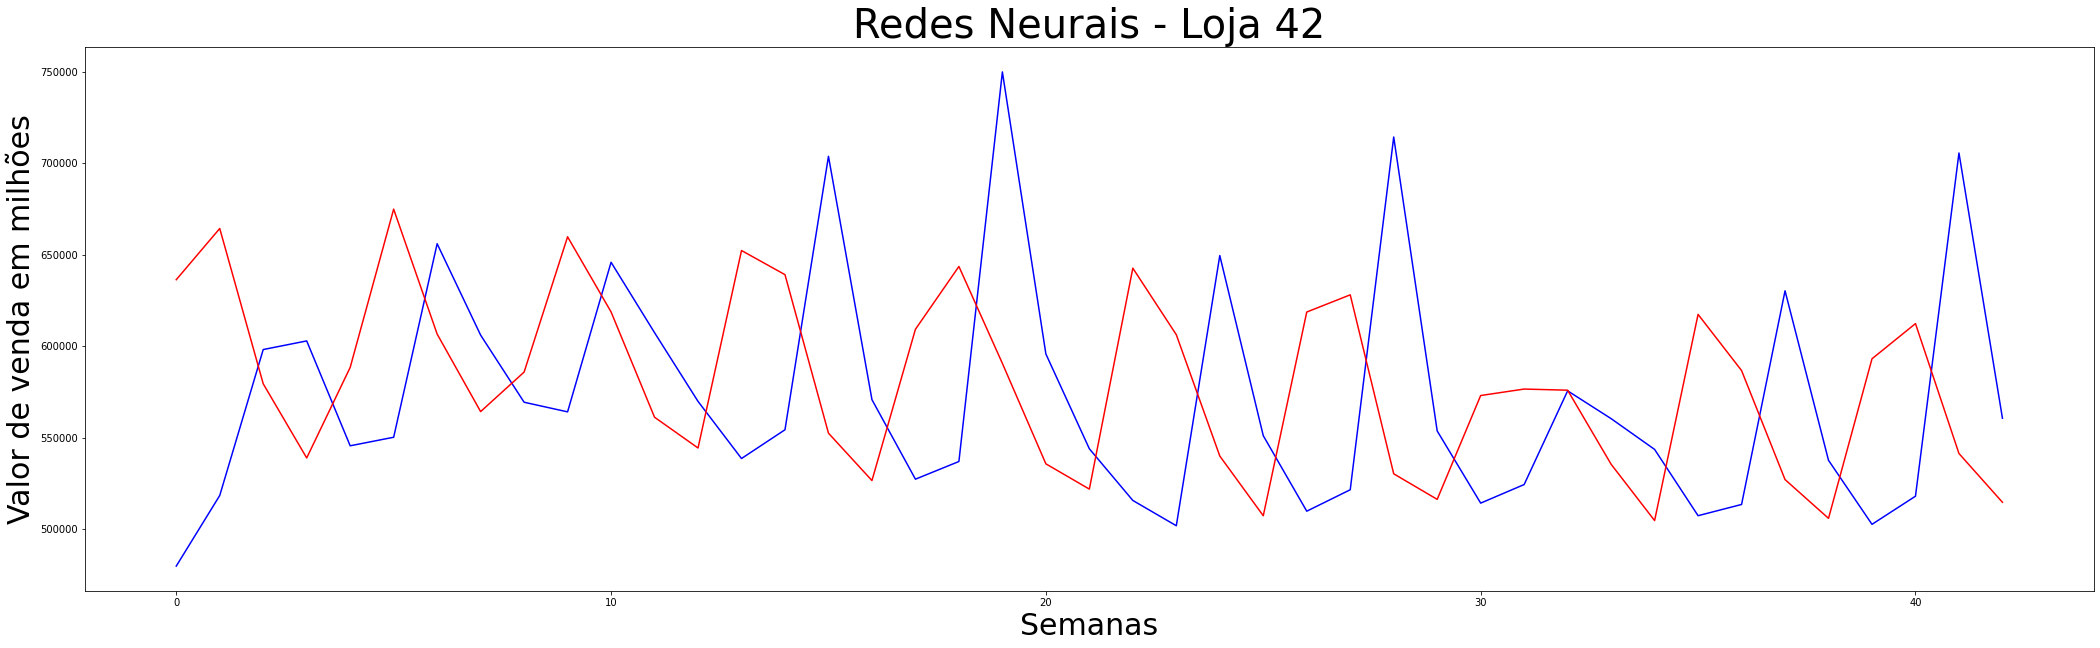

**************************************************
Resultados Loja 43:
-1.5179096413526039 36050.785 44636.836


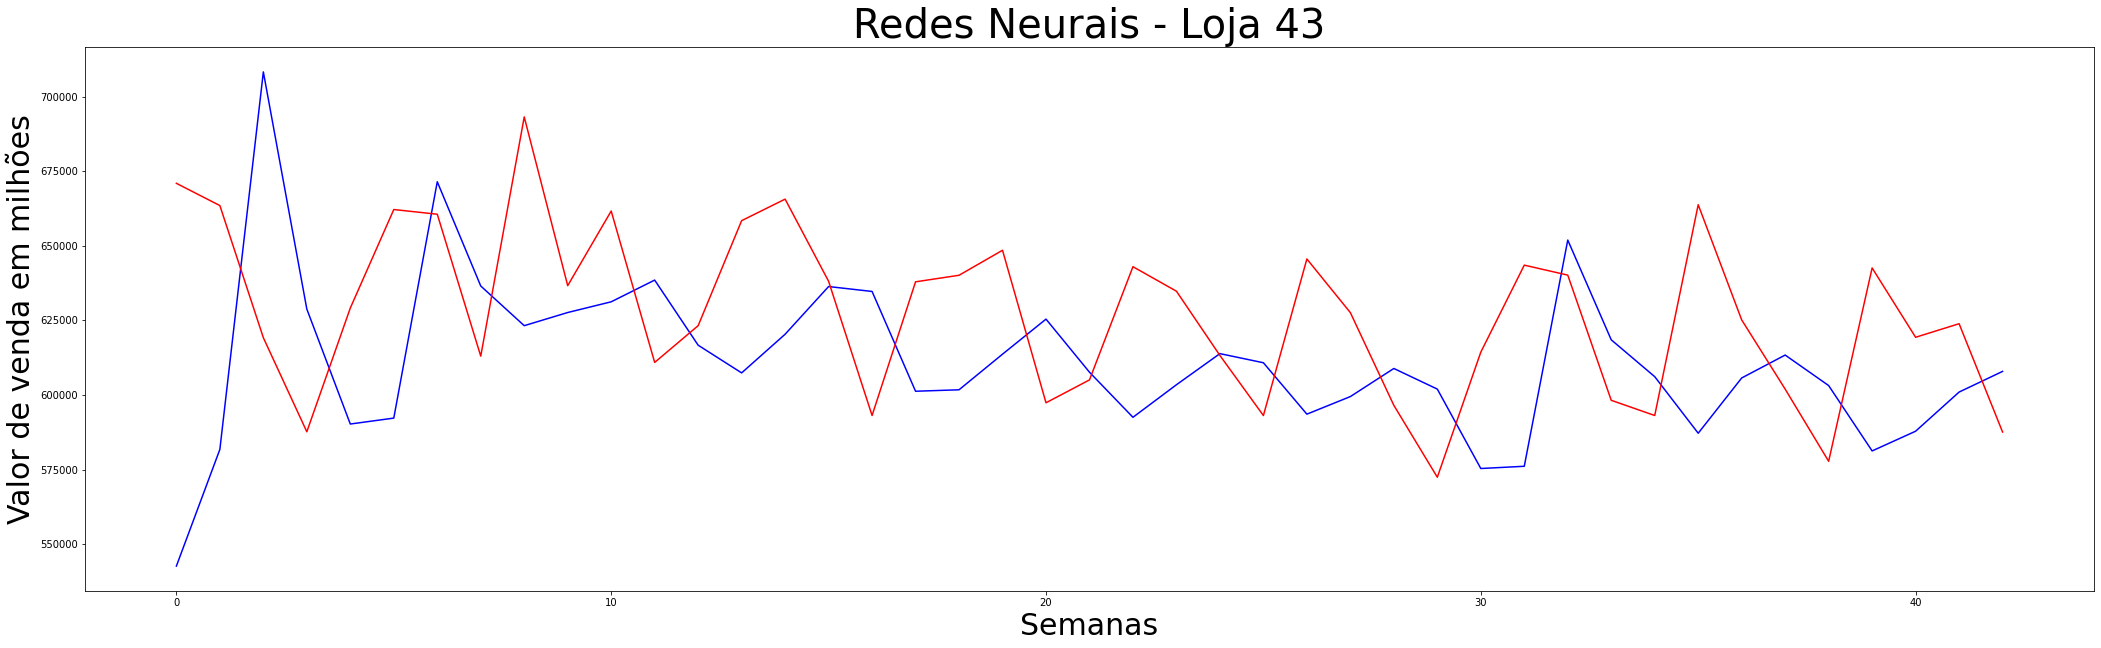

**************************************************
Resultados Loja 44:
-0.35481825550446566 13338.756 16239.051


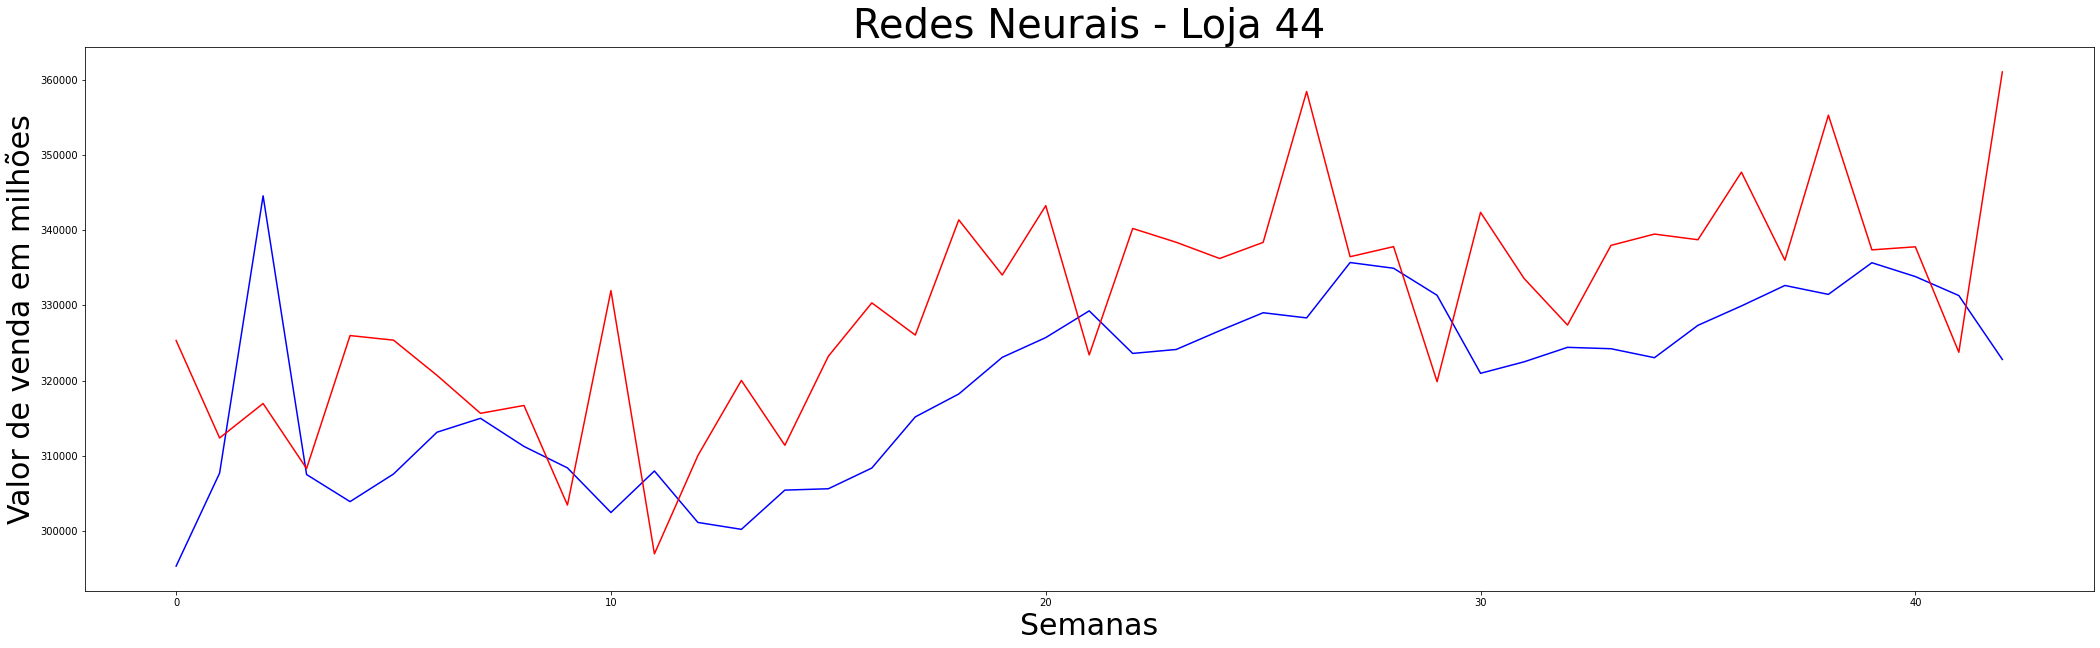

**************************************************
Resultados Loja 45:
-0.7239895858582759 45584.0 67776.984


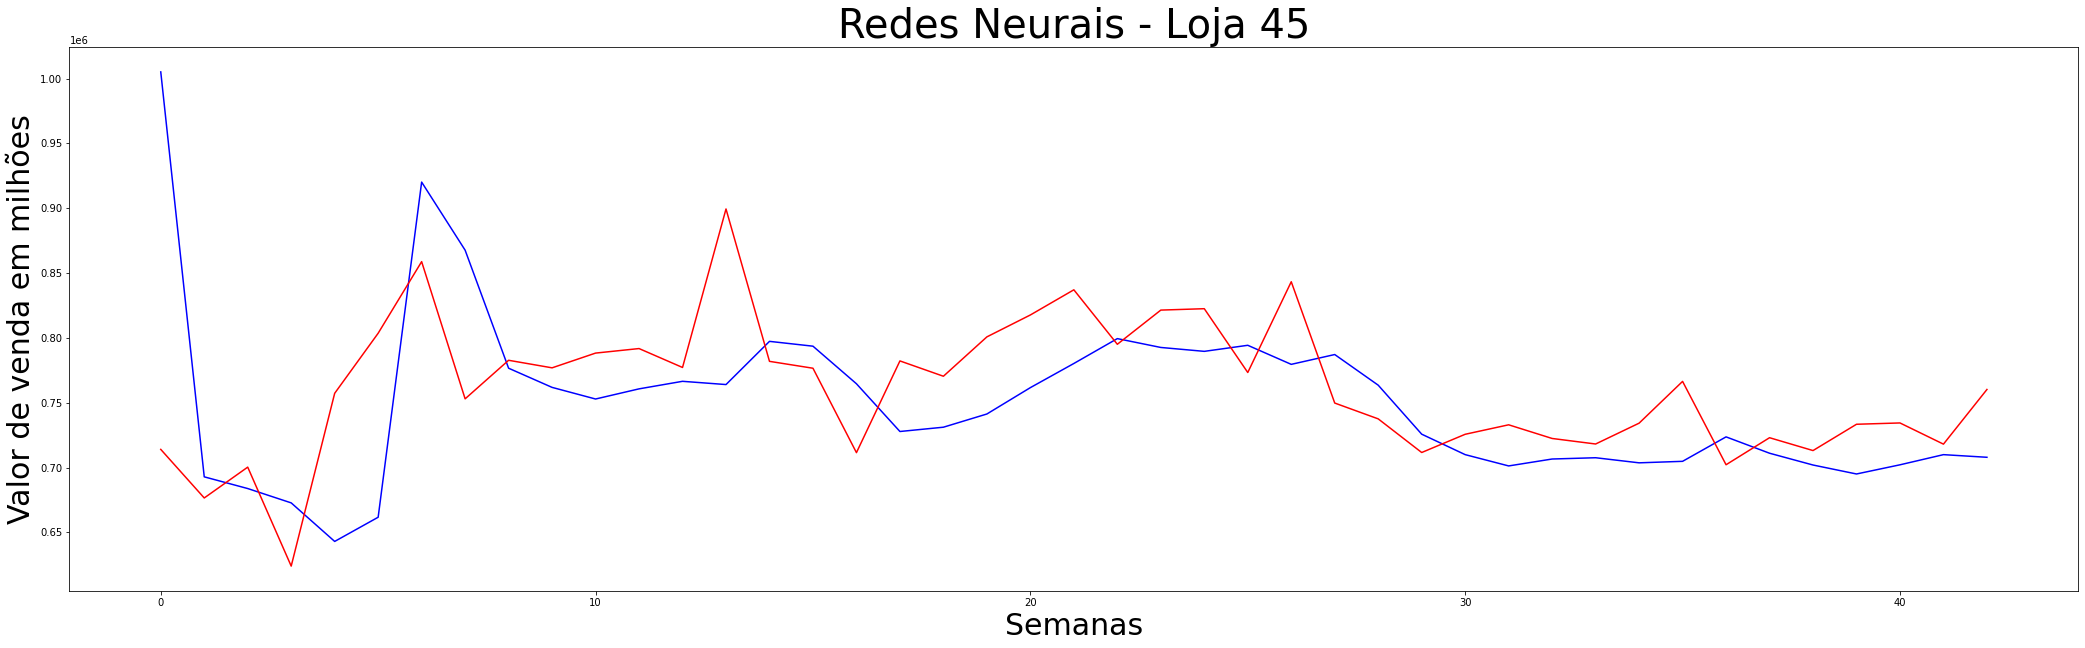

**************************************************


In [22]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = model.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(r2_score(y_loja, predictions_loja), mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Redes Neurais - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
